# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [50]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [51]:
# Take a quick look at demographics data
azdias.shape

(891221, 85)

In [52]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [53]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [54]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [55]:
# Take a look at feature info data
feat_info.shape

(85, 4)

In [56]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [57]:
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [58]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [59]:
# Identify missing or unknown data values and convert them to NaNs.

In [60]:
# Create a datatframe to store count of null values in each field before cleaning
null_value_counts = pd.DataFrame(azdias.isnull().sum(), columns=['original_missing'])

In [61]:
null_value_counts.sum()

original_missing    4896838
dtype: int64

In [62]:
# Where fields have no missing or unknown values specified in feat_info, investigate null values in these 
# columns to see if this can help me understand what nulls means in these fields.
fields = feat_info.loc[feat_info.missing_or_unknown=='[]','attribute'].values.tolist()
for field in fields:
    print(f'Field: {field}. Number of null values in data: {azdias[field].isnull().sum()}')
    print(f'Existing value counts: \n{azdias[field].value_counts()}')
    print('*'*100)

Field: GFK_URLAUBERTYP. Number of null values in data: 4854
Existing value counts: 
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
****************************************************************************************************
Field: GREEN_AVANTGARDE. Number of null values in data: 0
Existing value counts: 
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
****************************************************************************************************
Field: ANZ_PERSONEN. Number of null values in data: 73499
Existing value counts: 
1.0     423383
2.0     195470
3.0      94905
4.0      47126
0.0      34103
5.0      15503
6.0       4842
7.0       1525
8.0        523
9.0        180
10.0        67
11.0        38
12.0        16
13.0        11
21.0         4
14.0         4
20.0         3
15.0         3
38.

In [63]:
# GFK_URLAUBERTYP: Vacation habits (L1).  No obvious meaning for empty values. 4854 nulls.
# GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth (L1). 0 nulls.
# ANZ_PERSONEN: Number of adults in household (L2). No obvious meaning for missing values. 73499 nulls.
# ANZ_TITEL: Number of professional academic title holders in household (L2). No obvious meaning for missing values. 73499 nulls.
# ANZ_HH_TITEL: Number of professional academic title holders in building (L3). No obvious meaning for missing values. 97088 nulls.
# KONSUMNAEHE: Distance from building to point of sale (PoS) (L3). No obvious meaning for missing values. 73969 nulls.
# GEBAEUDETYP_RASTER: Ratio of residential to commercial activity (L7). No obvious meaning for missing values. 93155 nulls.
# MOBI_REGIO: Movement patterns (L7). No obvious meaning for missing values. 133324 nulls.
# ONLINE_AFFINITAET: Online affinity (L7). No obvious meaning for empty values. 4854 nulls.
# KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region (L8). No obvious meaning for empty values. 105800 nulls.

In [64]:
# Define a function to return a dictionary of attribute:list_of_missing_or_unknown_values key-value pairs
def return_null_value_dict(df):
    null_value_dict = {}

    # Insert all attributes in the feat_info dataframe as keys in the null_value_dict,
    # with the value for each attribute key being the list of missing or unknown values
    for attribute in df.attribute.values:
        # Create a list of null values from the feat_info dataframe for each attribute
        null_vals_list = df.loc[df.attribute==attribute,'missing_or_unknown'].values[0].strip('[]').split(',')
        # Parse data as correct type for each null value in the null_vals_list, allowing for integers, strings
        # and empty values.  Parse as None if there are no null values for the attribute
        updated_null_vals_list=[]
        for null_val in null_vals_list:
            if null_val:
                try:
                    # Append missing/unknown value as an integer if it can be cast as an integer
                    updated_null_vals_list.append(int(null_val))
                except:
                    # Otherwise append missing/unknown value as a string
                    updated_null_vals_list.append(null_val)
        null_value_dict[attribute] = updated_null_vals_list
    
    return null_value_dict

# Assign dictionary of attribute and attribute-specific null values
null_value_dict = return_null_value_dict(feat_info)

In [65]:
null_value_dict

{'AGER_TYP': [-1, 0],
 'ALTERSKATEGORIE_GROB': [-1, 0, 9],
 'ANREDE_KZ': [-1, 0],
 'CJT_GESAMTTYP': [0],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_VORSORGER': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZTYP': [-1],
 'GEBURTSJAHR': [0],
 'GFK_URLAUBERTYP': [],
 'GREEN_AVANTGARDE': [],
 'HEALTH_TYP': [-1, 0],
 'LP_LEBENSPHASE_FEIN': [0],
 'LP_LEBENSPHASE_GROB': [0],
 'LP_FAMILIE_FEIN': [0],
 'LP_FAMILIE_GROB': [0],
 'LP_STATUS_FEIN': [0],
 'LP_STATUS_GROB': [0],
 'NATIONALITAET_KZ': [-1, 0],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_KZ': [-1],


In [66]:
# Take a copy of uncleansed azdias data and replace all missing and unknown values with NaNs
demo = azdias.copy()
for (attribute, null_vals) in null_value_dict.items():
    if len(null_vals) > 0:
        mask = demo.loc[:, attribute].isin(null_vals)
        demo.loc[mask, attribute] = np.NaN          

In [67]:
# Verify correct replacement of missing and unknown values for several intentionally selected columns
print(azdias.AGER_TYP.value_counts(dropna=False))
print(demo.AGER_TYP.value_counts(dropna=False))
print('\n')
print(azdias.ALTERSKATEGORIE_GROB.value_counts(dropna=False))
print(demo.ALTERSKATEGORIE_GROB.value_counts(dropna=False))
print('\n')
print(azdias.CJT_GESAMTTYP.value_counts(dropna=False))
print(demo.CJT_GESAMTTYP.value_counts(dropna=False))
print('\n')
print(azdias.ANZ_TITEL.value_counts(dropna=False))
print(demo.ANZ_TITEL.value_counts(dropna=False))
print('\n')
print(azdias.CAMEO_DEUG_2015.value_counts(dropna=False))
print(demo.CAMEO_DEUG_2015.value_counts(dropna=False))
print('\n')
print(azdias.CAMEO_DEU_2015.value_counts(dropna=False))
print(demo.CAMEO_DEU_2015.value_counts(dropna=False))

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64
NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64


3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64
 3.0    358533
 4.0    228510
 2.0    158410
 1.0    142887
NaN       2881
Name: ALTERSKATEGORIE_GROB, dtype: int64


 4.0    210963
 3.0    156449
 6.0    153915
 2.0    148795
 5.0    117376
 1.0     98869
NaN       4854
Name: CJT_GESAMTTYP, dtype: int64
 4.0    210963
 3.0    156449
 6.0    153915
 2.0    148795
 5.0    117376
 1.0     98869
NaN       4854
Name: CJT_GESAMTTYP, dtype: int64


 0.0    814542
NaN      73499
 1.0      2970
 2.0       202
 3.0         5
 4.0         2
 6.0         1
Name: ANZ_TITEL, dtype: int64
 0.0    814542
NaN      73499
 1.0      2970
 2.0       202
 3.0         5
 4.0         2
 6.0         1
Name: ANZ_TITEL, dtype: int64


8      134441
9      108177
6      105874
4 

In [68]:
# Store new null value count after replacing missing and unknown values after cleaning
null_value_counts['new_missing'] = demo.isnull().sum()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [69]:
# Before doing any analysis on missing data in columns or rows, I want to see if any rows consist of NaNs only,
# as these can be dropped instantly
print(demo.shape)
print(demo.dropna(axis=1, how='all').shape)

# It appears there are no rows that contain NaNs only

(891221, 85)
(891221, 85)


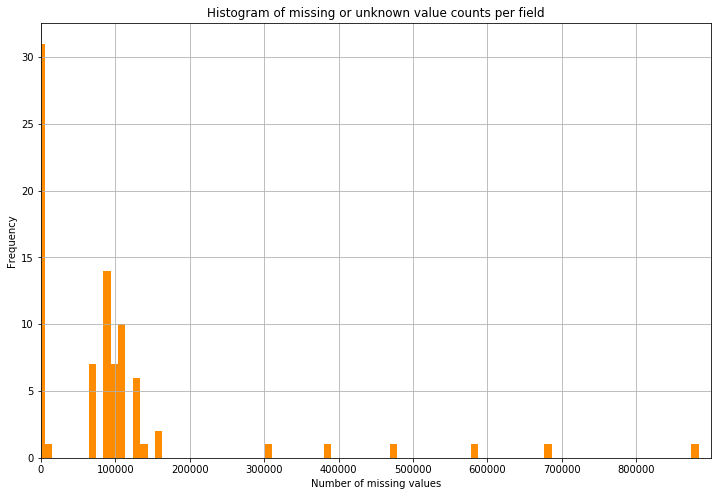

In [70]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Assign a series with the number of missing values in each column for plotting as a histogram
col_missing_val_count = demo.isnull().sum()

# Plot histogram of missing/unknown value counts for each field
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(col_missing_val_count, bins=90, color='darkorange', align='left')
ax.set_xlabel('Number of missing values')
ax.set_ylabel('Frequency')
ax.set_xlim(0,900000)
ax.set_xticks(range(0,900000,100000))
ax.set_title('Histogram of missing or unknown value counts per field')
ax.grid() ;

In [71]:
# There appears to be 6 fields with more than 200,000 missing values. 
# Identify columns with more than 200,000 missing values
null_value_counts[null_value_counts.new_missing > 200000]
# These can probably be removed as outlier columns in the next step.

# Interestingly, quite a few of the fields listed below are age-related

,original_missing,new_missing
AGER_TYP,0,685843
GEBURTSJAHR,0,392318
TITEL_KZ,73499,889061
ALTER_HH,73499,310267
KK_KUNDENTYP,584612,584612
KBA05_BAUMAX,133324,476524


In [72]:
# Investigate patterns in the amount of missing data in each column.

# Looking at the histogram, there appears to be 31 columns with between 90,000-120,000 missing values

# List these columns and display the number of missing values in each
print(null_value_counts[(null_value_counts.new_missing>90000) & (null_value_counts.new_missing<120000)].index.tolist())
print(null_value_counts[(null_value_counts.new_missing>90000) & \
                        (null_value_counts.new_missing<120000)].sort_values('new_missing', ascending=False))

# Looking at the list below, all the 'RR4 micro-cell features and 'PLZ8 macro-cell features' are in this list, as well as the 
# LEBENSPHASE (income-related fields).  

['HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'VERS_TYP', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']
                       original_missing  new_missing
PLZ8_GBZ                         116515       116515
PLZ8_HHZ                         116515       116515
PLZ8_BAUMAX                      116515       116515
PLZ8_ANTG4                       116515       116515
PLZ8_ANTG3                       116515       116515
PLZ8_ANTG2                       116515       116515
PLZ8_ANTG1                       116515       116515
HEALTH_TYP                            0       111196
SHOPPER_TYP          

In [73]:
# There are an additional 7 fields with between 70,000 and 80,000 missing values

# List these columns 
print(null_value_counts[(null_value_counts.new_missing>70000) & (null_value_counts.new_missing<80000)].index.tolist())
print(null_value_counts[(null_value_counts.new_missing>70000) & \
                        (null_value_counts.new_missing<80000)].sort_values('new_missing', ascending=False))

['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008', 'KONSUMNAEHE']
                 original_missing  new_missing
LP_FAMILIE_FEIN              4854        77792
LP_FAMILIE_GROB              4854        77792
KONSUMNAEHE                 73969        73969
SOHO_KZ                     73499        73499
ANZ_PERSONEN                73499        73499
ANZ_TITEL                   73499        73499
WOHNDAUER_2008              73499        73499


In [74]:
# There are an additional 6 fields with between 130,000 and 140,000 missing values

# List these columns 
print(null_value_counts[(null_value_counts.new_missing>130000) & (null_value_counts.new_missing<140000)].index.tolist())
print(null_value_counts[(null_value_counts.new_missing>130000) & \
                        (null_value_counts.new_missing<140000)].sort_values('new_missing', ascending=False))

['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']
             original_missing  new_missing
KBA05_ANTG1            133324       133324
KBA05_ANTG2            133324       133324
KBA05_ANTG3            133324       133324
KBA05_ANTG4            133324       133324
KBA05_GBZ              133324       133324
MOBI_REGIO             133324       133324


In [75]:
# Remove the outlier columns from the dataset

outlier_cols = null_value_counts[null_value_counts.new_missing > 200000].index.tolist()
demo.drop(columns=outlier_cols, inplace=True)

# Remove outlier_cols from null_value_counts too
null_value_counts = null_value_counts[~null_value_counts.index.isin(outlier_cols)]

In [76]:
null_value_counts.head()

,original_missing,new_missing
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0


In [77]:
# Add information_Level to null_value_counts to help identify patterns between number of missing or unknown 
# values and information_level of attribute, as the anylysis above suggests there are groupings of missing 
# values based on the information_level of the attribute
null_value_counts = null_value_counts.merge(feat_info[['attribute','information_level']], left_index=True, right_on='attribute', \
                        how='inner').set_index('attribute')

# For each information_level print number of missing or unknown values for each field assigned to this information_level
for info_level in null_value_counts.information_level.unique():
    missing_value_counts = null_value_counts.loc[null_value_counts.information_level==info_level,'new_missing'].values.tolist()
    print(f'Information level: {info_level}.  Missing value counts:{missing_value_counts}')
    print('\n')

Information level: person.  Missing value counts:[2881, 0, 4854, 0, 0, 0, 0, 0, 0, 0, 4854, 0, 111196, 97632, 94572, 77792, 77792, 4854, 4854, 108315, 108164, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111196, 73499, 111196, 0]


Information level: household.  Missing value counts:[73499, 73499, 18348, 147988, 73499]


Information level: building.  Missing value counts:[99611, 97008, 93148, 73969, 93148, 93148, 93148]


Information level: microcell_rr4.  Missing value counts:[99352, 99352, 99352]


Information level: microcell_rr3.  Missing value counts:[133324, 133324, 133324, 133324, 133324]


Information level: postcode.  Missing value counts:[93740, 93740, 93740]


Information level: region_rr1.  Missing value counts:[93155, 158064, 133324, 4854, 158064]


Information level: macrocell_plz8.  Missing value counts:[105800, 116515, 116515, 116515, 116515, 116515, 116515, 116515]


Information level: community.  Missing value counts:[97375, 97274, 97375]




#### Discussion 1.1.2: Assess Missing Data in Each Column
There are 6 columns that had more than 200,000 missing values.  These were 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH',
 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.  They were all dropped from the dataset as they were outliers in terms of their number of missing or unknown values.  A lot (but not all) of these fields were age-related and all (with the exception of 'KBA05_BAUMAX') were person and household level features.
 
Of the reamining 79 features, the number of missing or unknown values appears to be related to the information-level of the attribute - see summary below.  
1. Person-level features. 40 fields - 24 with 0, 1 with 2,881, 5 with 4,854, 1 with 73,499, 2 with 77792, 7 with 90,000+ missing or unknown values
2. Household-level features. 5 fields - 3 with 73499, 1 with 147,988 and 1 with 18,348 missing or unknown values.
3. Building-level features. 7 fields - 4 with 93,148, 1 with 99,611, 1 with 97,008 and 1 with 73,969 missing or unknown values. 
4. RR4 micro-cell features. 3 fields - all with 99,352 missing or unknown values
5. RR3 micro-cell features. 5 fields - all with 133,324 missing or unknown values.
6. Postcode-level features. 3 fields - all with 93,740 missing or unknown values.
7. RR1 region features. 5 fields - 2 fields with 158,604 and 1 field (each) with 133324, 93155, 4854 missing or unknown values
8. PLZ8 macro-cell features. 8 fields - 7 fields with 116,515 and 1 field with 105,800 missing or unknown values.
9. Community-level features.  3 fields - 2 fields with 97,375 and 1 field with 97,274 missing or unknown values.  

Of the remaining 79 fields (after the 6 fields with more than 200,000 missing or unknown values have been removed from the orignal data), there are 40 fields with more than 90,000 missing or unknown values.  Of the remaining 39 fields:

- 24 have 0 missing or unknown values
- 1 has 2,881 missing or unknown values: ALTERSKATEGORIE_GROB (1 person-level)
- 6 have 4,854 missing or unknown values: CJT_GESAMTTYP, GFK_URLAUBERTYP, LP_STATUS_FEIN, LP_STATUS_GROB, RETOURTYP_BK_S (5 person level), 	ONLINE_AFFINITAET (1 rr1 region-level)
- 1 has beetween 10,000 and 20,000 missing or unknown values: HH_EINKOMMEN_SCORE (household-level)
- 7 have between 70,000 and 80,000 missing or unknown values: ANZ_PERSONEN, ANZ_TITEL, WOHNDAUER_2008 (3 household-level) and SOHO_KZ (1 person-level) have 73,499; LP_FAMILIE_FEIN, LP_FAMILIE_GROB (2 person-level) have 77, 792; KONSUMNAEHE (building-level) has 73,969 missing or unknown values.

I may consider dropping some of these columns later, but will retain them for non, pending investigation of missing data at row level.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

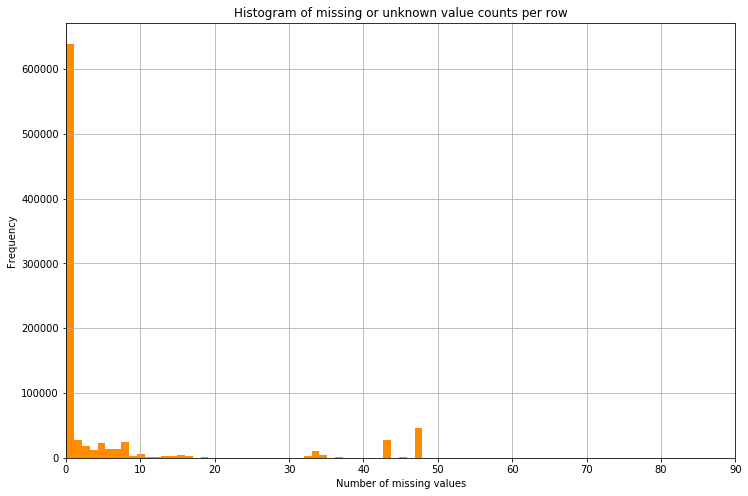

In [78]:
# How much data is missing in each row of the dataset?

# Create a series of null data counts for each row
null_value_counts_row = demo.isnull().sum(axis=1)

# Plot histogram of missing/unknown value counts for each row
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(null_value_counts_row, bins=46, color='darkorange', align='mid')
ax.set_xlabel('Number of missing values')
ax.set_ylabel('Frequency')
ax.set_xlim(0,90)
ax.set_title('Histogram of missing or unknown value counts per row')
ax.grid() ;

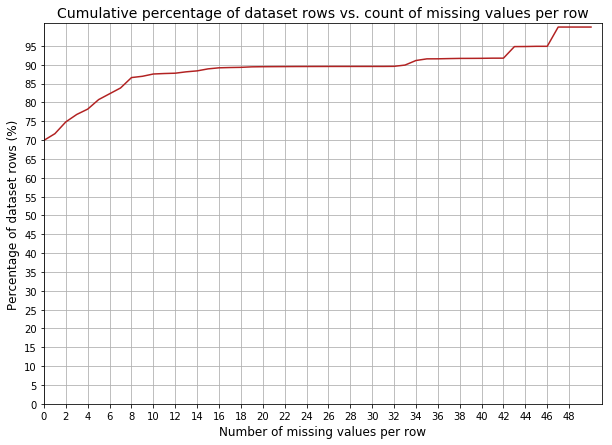

In [79]:
# Calculate cumulative percentage of dataset rows over the range of missing value counts in dataset rows
missing_row_cum_sum = np.cumsum(null_value_counts_row.value_counts().sort_index() / demo.shape[0] *100)
# Forward fill cumulative sum to account for NaNs in series i.e. value_count for X missing values = 0
missing_row_cum_sum = pd.Series(index=range(0,51), data=missing_row_cum_sum).ffill()

fig,ax = plt.subplots(figsize=(10,7))
ax.plot(range(0,51), missing_row_cum_sum, c='firebrick')
ax.set_ylim(0,101)
ax.set_xlim(0,51)
ax.set_xticks(range(0,50,2))
ax.set_yticks(range(0,100,5))
ax.grid()
ax.set_ylabel('Percentage of dataset rows (%)', size=12)
ax.set_xlabel('Number of missing values per row', size=12)
ax.set_title('Cumulative percentage of dataset rows vs. count of missing values per row', size=14) ;

In [80]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


# Set threshold for dividing data based on number of missing values in each row
# Based on the plot above, I'll set the threshold at 8 missing values per row.  This threshold leaves me with
# ~87% of the dataset's rows.  The return from increasing this threshold 
missing_row_values_threshold = 8

# Split data set based on number of missing values in each row
demo_s1 = demo[null_value_counts_row<=missing_row_values_threshold]
demo_s2 = demo[null_value_counts_row>missing_row_values_threshold]

# Print shape of split datasets and proprtion of dataset rows these splits account for
print(demo_s1.shape, round(len(demo_s1)/len(demo)*100,2))
print(demo_s2.shape, round(len(demo_s2)/len(demo)*100,2))


(771701, 79) 86.59
(119520, 79) 13.41


In [81]:
# Use this code to help me select the fields to compare in the cell below
null_value_counts[null_value_counts.new_missing<50000].sort_values('new_missing')

,original_missing,new_missing,information_level
attribute,,,
SEMIO_SOZ,0,0,person
SEMIO_ERL,0,0,person
SEMIO_LUST,0,0,person
SEMIO_VERT,0,0,person
SEMIO_MAT,0,0,person
SEMIO_REL,0,0,person
SEMIO_FAM,0,0,person
SEMIO_KRIT,0,0,person
SEMIO_DOM,0,0,person


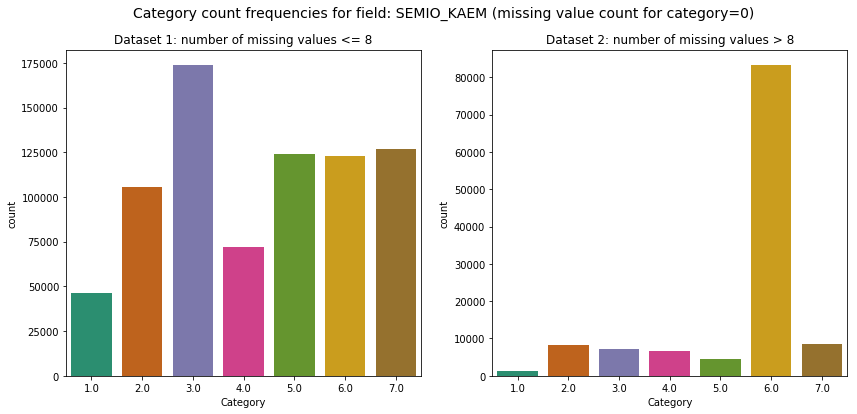

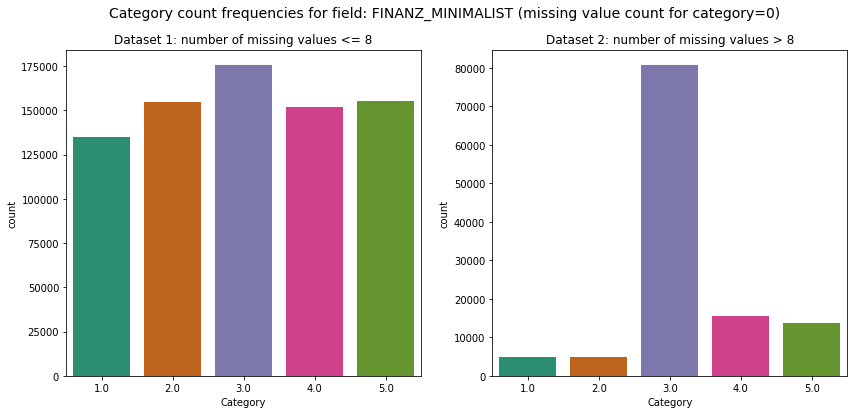

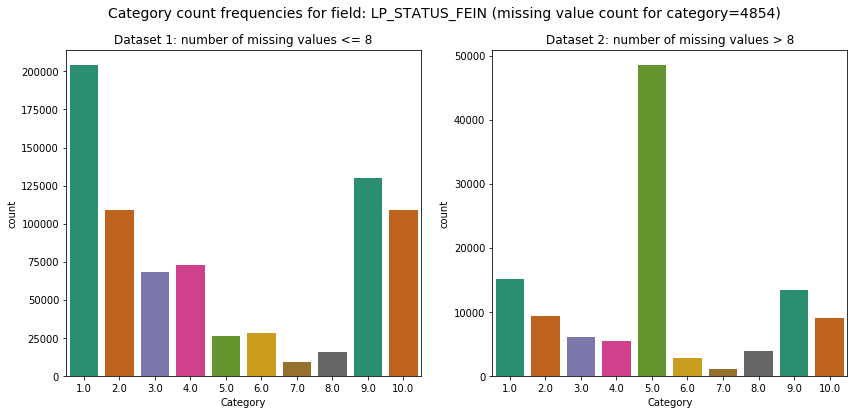

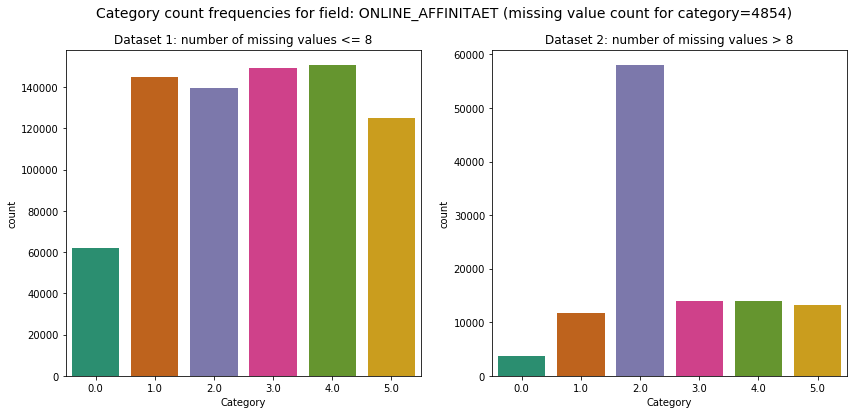

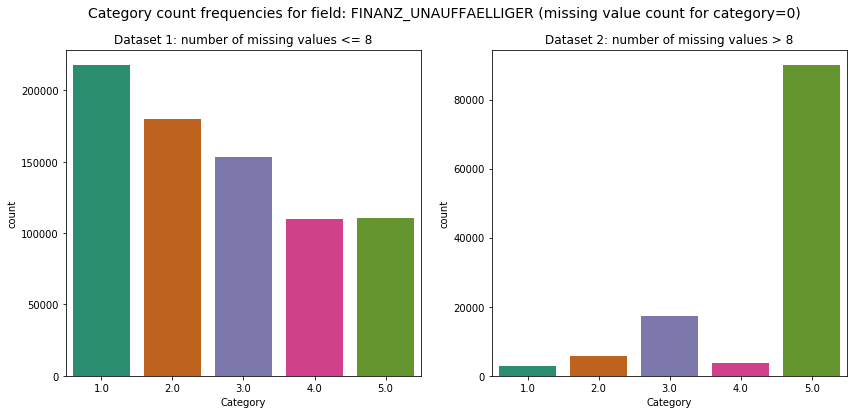

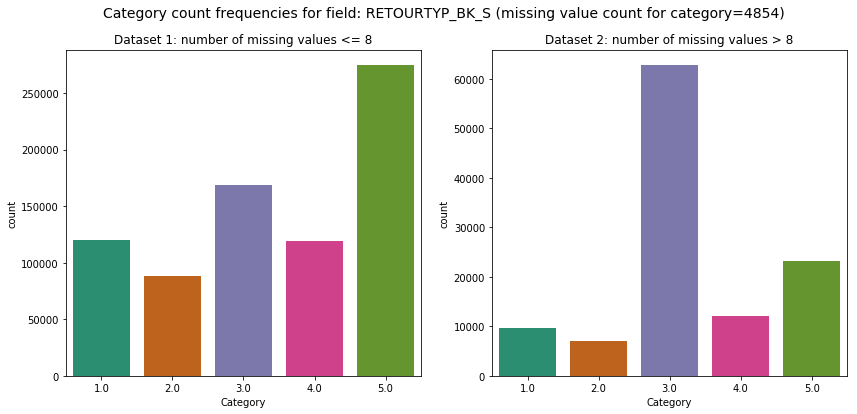

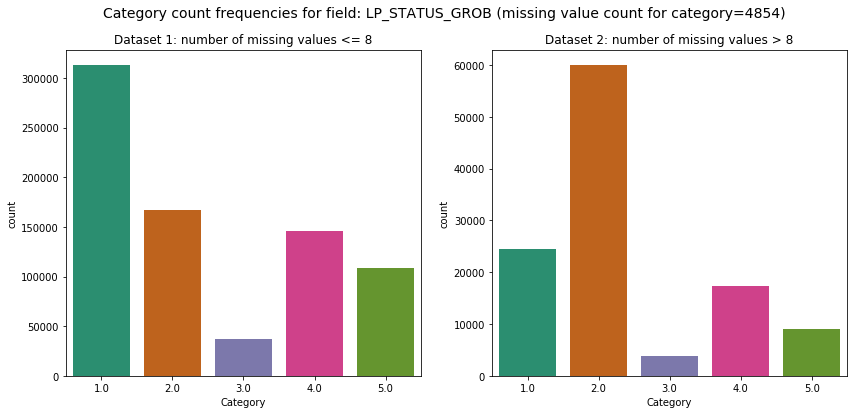

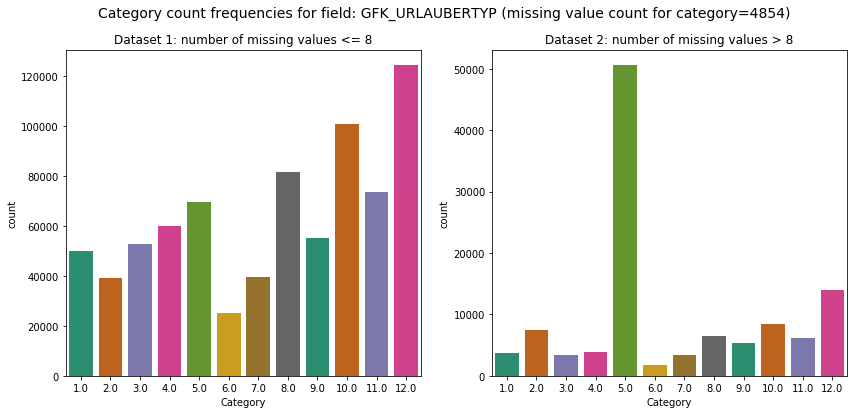

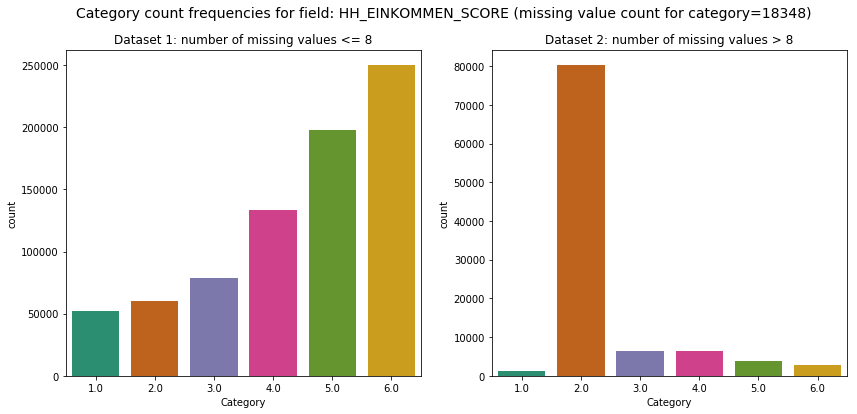

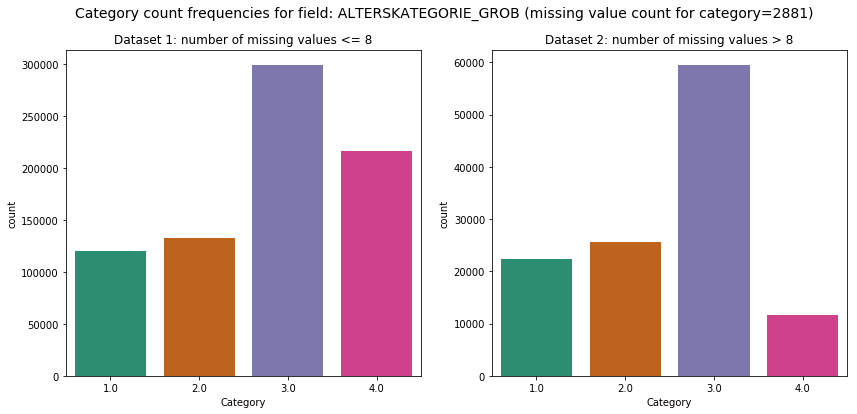

In [82]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Define a function to output a countplot of a column passed to the function,
# comparing the 2 subsets of data
def display_countplots(col):
    fig,ax = plt.subplots(figsize=(14,6), ncols=2)
    sns.countplot(x=col, data=demo_s1, palette='Dark2', ax=ax[0])
    sns.countplot(x=col, data=demo_s2,  palette='Dark2', ax=ax[1])
    ax[0].set_title(f'Dataset 1: number of missing values <= {missing_row_values_threshold}')
    ax[1].set_title(f'Dataset 2: number of missing values > {missing_row_values_threshold}')
    ax[0].set_xlabel('Category')
    ax[1].set_xlabel('Category')
    missing_val_count = null_value_counts.loc[null_value_counts.index==col,'new_missing'].values[0]
    fig.suptitle(f'Category count frequencies for field: {col} (missing value count for category={missing_val_count})', \
                 size=14) ;


# Define list of fields to be compared
comp_fields = ['SEMIO_KAEM', 'FINANZ_MINIMALIST', 'LP_STATUS_FEIN', 'ONLINE_AFFINITAET', 'FINANZ_UNAUFFAELLIGER', \
              'RETOURTYP_BK_S', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'ALTERSKATEGORIE_GROB' ]

# Call function for fields in list of compa_fields to generate comparison plots
for field in comp_fields:
    display_countplots(field)

In [83]:
demo_s1.isnull().sum().sort_values(ascending=False)

W_KEIT_KIND_HH           53736
KKK                      52343
REGIOTYP                 52343
LP_LEBENSPHASE_FEIN      40705
LP_LEBENSPHASE_GROB      38107
HEALTH_TYP               32488
SHOPPER_TYP              32488
VERS_TYP                 32488
NATIONALITAET_KZ         30005
PRAEGENDE_JUGENDJAHRE    24329
LP_FAMILIE_GROB          23698
LP_FAMILIE_FEIN          23698
MOBI_REGIO               22808
KBA05_GBZ                22808
KBA05_ANTG4              22808
KBA05_ANTG3              22808
KBA05_ANTG2              22808
KBA05_ANTG1              22808
PLZ8_ANTG1                7224
PLZ8_ANTG2                7224
PLZ8_ANTG3                7224
PLZ8_ANTG4                7224
PLZ8_BAUMAX               7224
PLZ8_HHZ                  7224
PLZ8_GBZ                  7224
ANZ_HAUSHALTE_AKTIV       5404
KBA13_ANZAHL_PKW          5033
ARBEIT                    3855
RELAT_AB                  3855
ORTSGR_KLS9               3772
                         ...  
FINANZ_UNAUFFAELLIGER        0
FINANZ_A

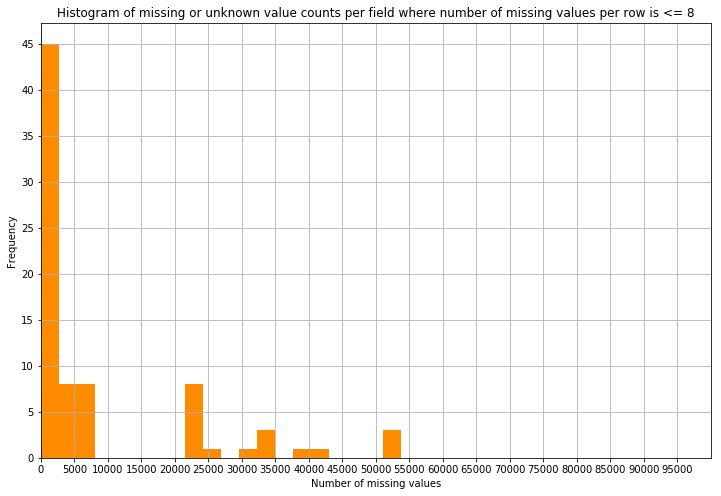

In [84]:
# Plot histogram of missing/unknown value counts for each field for rows with <= 8 missing values
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(demo_s1.isnull().sum(), bins=20, color='darkorange', align='mid')
ax.set_xlabel('Number of missing values')
ax.set_ylabel('Frequency')
ax.set_xlim(0,100000)
ax.set_xticks(range(0,100000,5000))
ax.set_yticks(range(0,50,5))
ax.set_title('Histogram of missing or unknown value counts per field where number of missing values per row is <= 8')
ax.grid() ;

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Approximately 70% of rows have 0 missing values.  A threshold of 8 or less missing values per row, accounts for 87% of the dataset's rows.  Up to 33 and 45 missing values per row must be allowed for to account for 90% and 95% of the dataset's rows respectively.  Based on what I know now, setting a maximum threshold of 8 missing values per row feels reasonable - allowing for any more missing values per row yields diminishing returns in terms of the number of rows accounted for in the dataset.


When dividing the data into 2 subsets: 1 with 8 missing values or less per row and with 1 with more than 8 missing values per row, the distribution of a range of feature's values was examined.  This analysis focussed on features with fewer minimum values, as identified in the previous step.  For some features it was found that the distribution of values was similar between the 2 subsets of data (e.g. 'ALTERSKATEGORIE_GROB', 'RETOURTYP_BK_S', 'LP_STATUS_GROB'), while the distributions varied greatly for others (e.g. 'HH_EINKOMMEN_SCORE', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_KAEM').


Finally, setting a threshold of no more than 8 missing values per row on the dataset yielded some interesting results:
- 45 of the remaining 79 features had 0 missing values - an increase from 31 features before this threshold was applied
- An additional 16 features had less than 8,000 missing values - meaning that a total of 61 (of 79) features had less than 8,000 missing values
- 18 (of 79) fields had more than 20,000 missing values

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [85]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [86]:
# Ignoring the 6 features removed in a previous step
feat_info.loc[~feat_info.attribute.isin(outlier_cols),'type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [87]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [88]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Display unique values in each categorical value
cat_fields = feat_info.loc[feat_info.type=='categorical','attribute'].values.tolist()
for field in cat_fields:
    # Ignore 6 outlier columns removed from data in previous step
    if field not in outlier_cols:
        field_vals = demo_s1[field].unique().tolist()
        #field_vals = [val for val in field_vals if str(val) != 'nan']
        print(field, field_vals)


ANREDE_KZ [2.0, 1.0]
CJT_GESAMTTYP [5.0, 3.0, 2.0, 4.0, 1.0, 6.0]
FINANZTYP [1.0, 6.0, 5.0, 2.0, 4.0, 3.0]
GFK_URLAUBERTYP [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 2.0, 6.0]
GREEN_AVANTGARDE [0, 1]
LP_FAMILIE_FEIN [5.0, 1.0, nan, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, 9.0, 3.0]
LP_FAMILIE_GROB [3.0, 1.0, nan, 5.0, 2.0, 4.0]
LP_STATUS_FEIN [2.0, 3.0, 9.0, 4.0, 1.0, 10.0, 5.0, 8.0, 6.0, 7.0]
LP_STATUS_GROB [1.0, 2.0, 4.0, 5.0, 3.0]
NATIONALITAET_KZ [1.0, 3.0, 2.0, nan]
SHOPPER_TYP [3.0, 2.0, 1.0, 0.0, nan]
SOHO_KZ [1.0, 0.0]
VERS_TYP [2.0, 1.0, nan]
ZABEOTYP [5.0, 3.0, 4.0, 1.0, 6.0, 2.0]
GEBAEUDETYP [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
OST_WEST_KZ ['W', 'O']
CAMEO_DEUG_2015 ['8', '4', '2', '6', '1', '9', '5', '7', '3', nan]
CAMEO_DEU_2015 ['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', nan, '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7

In [89]:
# Re-encode categorical variable(s) to be kept in the analysis.

# No need to re-encode: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ as these are binary categorical features

# Create list of categorical features requiring one-hot encoding
# Note, since I'll dummify these categorical variables, OST_WEST_KZ can be dummified in the same way
cat_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', \
            'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'OST_WEST_KZ']

# Create list of categorical features containining NaNs
nan_cat_cols = ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', \
                'VERS_TYP', 'CAMEO_DEUG_2015']


In [90]:
# Look at value_counts for categorical features containining NaNs to see if I can identify a sensible way 
# to impute or manage the missing values
for col in nan_cat_cols:
    print(demo_s1[col].value_counts(dropna=False))

 1.0     392886
 10.0    126755
 2.0      95786
 11.0     48119
NaN       23698
 8.0      21254
 7.0      18639
 4.0      11225
 5.0      10946
 9.0      10261
 6.0       7744
 3.0       4388
Name: LP_FAMILIE_FEIN, dtype: int64
 1.0    392886
 5.0    185135
 2.0     95786
 4.0     47637
 3.0     26559
NaN      23698
Name: LP_FAMILIE_GROB, dtype: int64
 1.0    648074
 2.0     62112
 3.0     31510
NaN      30005
Name: NATIONALITAET_KZ, dtype: int64
 1.0    238540
 2.0    202525
 3.0    172832
 0.0    125316
NaN      32488
Name: SHOPPER_TYP, dtype: int64
 2.0    386594
 1.0    352619
NaN      32488
Name: VERS_TYP, dtype: int64
8      132291
9      106263
6      103335
4      100185
3       82238
2       80039
7       75983
5       52773
1       35255
NaN      3339
Name: CAMEO_DEUG_2015, dtype: int64


In [91]:
# Same number of NaNs for LP_FAMILIE_FEIN and LP_FAMILIE_GROB - likely to be the same rows
# Same number of NaNs for VERS_TYP and SHOPPER_TYP - likely to be the same rows
# Small number of NaNs for CAMEO_DEUG_2015
# Redo analysis above with rows contanining these NaNs removed
for col in nan_cat_cols:
    mask = (~demo_s1.LP_FAMILIE_FEIN.isnull())&(~demo_s1.VERS_TYP.isnull())&(~demo_s1.CAMEO_DEUG_2015.isnull())
    print(demo_s1.loc[mask,col].value_counts(dropna=False))

print()
# Print percentage size of resulting filtered dataset with these NaN rows filtered out
print(round(demo_s1[mask].shape[0]/demo_s1.shape[0]*100,2))

print()
# Print percentage size of filtered dataset compared to original dataset
print(round(demo_s1[mask].shape[0]/azdias.shape[0]*100,2))

1.0     370840
10.0    121999
2.0      91225
11.0     46614
8.0      20654
7.0      17986
4.0      10774
5.0      10628
9.0       9945
6.0       7455
3.0       4168
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    370840
5.0    178558
2.0     91225
4.0     46095
3.0     25570
Name: LP_FAMILIE_GROB, dtype: int64
1.0    622887
2.0     59740
3.0     29661
Name: NATIONALITAET_KZ, dtype: int64
1.0    229617
2.0    196073
3.0    164494
0.0    122104
Name: SHOPPER_TYP, dtype: int64
2.0    372053
1.0    340235
Name: VERS_TYP, dtype: int64
8    120792
6     95686
9     95055
4     94426
3     77926
2     76017
7     69993
5     49140
1     33253
Name: CAMEO_DEUG_2015, dtype: int64

92.3

79.92


In [92]:
# Apply mask to filter out rows with NaNs in categorical features
demo_s3 = demo_s1[mask]

# Dummify all categorical features
demo_s4 = pd.get_dummies(demo_s3, columns=cat_cols+nan_cat_cols, drop_first=True)

# Print shape of dataframes to confirm they are as expected
print(demo_s1.shape)
print(demo_s3.shape)
print(demo_s4.shape)

(771701, 79)
(712288, 79)
(712288, 181)


#### Discussion 1.2.1: Re-Encode Categorical Features

Of the 18 categorical fields remaining in my data, 3 were binary and did not require encoding, 9 were multi-level categoricals without NaNs and could be one-hot encoded as-is and 6 fields were multi-level categoricals containing NaNs.

Since the 6 fields containing NaNs couldn't be effectively encoded without managing the NaNs, I examined the distribution of value counts (including NaNs) for each of these categorical features.  With the exception of the NATIONALITAET_KZ field, all fields contained a good distribution of values and hence, I felt they could contain useful information.  For fields where the vast majority of values were the same (such as NATIONALITAET_KZ), I was less concerned about dropping these features as they contain less information.

After realising that the count of NaN values was the same for some of these fields, I decided to drop the rows that contained NaN values for these fields.  By dropping 59,413 rows or 8% of the rows, I was able to retain all 6 of the categorical features that had previously contained NaNs.  With this additional 8% of rows dropped, my dataset now contains 80% of the rows from the original dataset, which I'm OK with.  

I feel it will be easier to impute non categorical variables, so I'm not overly concerned about dropping rows to retain the information held in categorical features that contain NaNs.

Lastly, I dropped the first value for each dummififed categorical variable to eliminate these redundant features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [93]:
# Reset index before further cleaning
demo_s4.reset_index(drop=True, inplace=True)

In [94]:
# Create and display list of mixed-type features
mt_feats = feat_info.loc[(~feat_info.attribute.isin(outlier_cols))&(feat_info.type=='mixed'),'attribute'].values.tolist()
print(mt_feats)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [95]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Display value counts for feature
print(demo_s4.PRAEGENDE_JUGENDJAHRE.value_counts(dropna=False))


 14.0    166154
 8.0     130409
 10.0     78891
 5.0      77959
 3.0      48978
 15.0     38575
 11.0     32947
 9.0      31732
 6.0      24161
 12.0     22894
 4.0      19231
 1.0      17194
NaN        7529
 2.0       6530
 13.0      5321
 7.0       3783
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [96]:
# There are a small number of NaN rows in the data.  I'll drop these before engineering the mixed features
demo_s5 = demo_s4[~demo_s4.PRAEGENDE_JUGENDJAHRE.isnull()].reset_index(drop=True)

# Define function to take 2-digit 'PRAEGENDE_JUGENDJAHRE' code and return movement and generation
# codes associated witt it
def movement_splitter(code):
    mainstream_codes = [1 ,3 ,5, 8, 10, 12, 14] 
    if code in mainstream_codes:
        movement = 'mainstream'
    else:
        movement = 'avantgarde'
    
    # Define a dictionary of generation codes
    gen_codes = {1:'40s', 2:'40s', 3:'50s', 4:'50s', 5:'60s', 6:'60s', 7:'60s', 8:'70s', \
                 9:'70s', 10:'80s', 11:'80s', 12:'80s', 13:'80s', 14:'90s', 15:'90s'}
        
    if code in gen_codes:
        gen = gen_codes[code]
    
    return movement, gen

# Create new feature and dummify the values
PRAEGENDE_JUGENDJAHRE_split = pd.DataFrame(demo_s5.PRAEGENDE_JUGENDJAHRE.map(movement_splitter).tolist(), \
                        columns=['PRAEGENDE_JUGENDJAHR_MOVEMENT', 'PRAEGENDE_JUGENDJAHR_GEN'])

PRAEGENDE_JUGENDJAHRE_split = pd.get_dummies(PRAEGENDE_JUGENDJAHRE_split, drop_first=True)

In [97]:
# Verify engineering of dummified features
print(demo_s5.PRAEGENDE_JUGENDJAHRE.head(10))
PRAEGENDE_JUGENDJAHRE_split.head(10)

0    14.0
1    15.0
2     8.0
3     3.0
4    10.0
5     8.0
6    11.0
7    15.0
8     3.0
9     8.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64


,PRAEGENDE_JUGENDJAHR_MOVEMENT_mainstream,PRAEGENDE_JUGENDJAHR_GEN_50s,PRAEGENDE_JUGENDJAHR_GEN_60s,PRAEGENDE_JUGENDJAHR_GEN_70s,PRAEGENDE_JUGENDJAHR_GEN_80s,PRAEGENDE_JUGENDJAHR_GEN_90s
0,1,0,0,0,0,1
1,0,0,0,0,0,1
2,1,0,0,1,0,0
3,1,1,0,0,0,0
4,1,0,0,0,1,0
5,1,0,0,1,0,0
6,0,0,0,0,1,0
7,0,0,0,0,0,1
8,1,1,0,0,0,0
9,1,0,0,1,0,0


In [98]:
# Replace 'PRAEGENDE_JUGENDJAHR_MOVEMENT' with dummified split features
# Print dataframe shape at each step to ensure shape is aligned with expectation
print(demo_s5.shape)
demo_s5.drop(labels=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
print(demo_s5.shape)
demo_s6 = demo_s5.merge(PRAEGENDE_JUGENDJAHRE_split, left_index=True, right_index=True, how='inner')
print(demo_s6.shape)

(704759, 181)
(704759, 180)
(704759, 186)


In [125]:
# Losing some information (east vs west) here 

In [99]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Reset index after dropping rows above
demo_s6.reset_index(drop=True, inplace=True)

# Print feature's value_counts
print(demo_s6.CAMEO_INTL_2015.value_counts(dropna=False))

51    116860
24     82674
41     82188
14     57169
43     50897
54     39946
25     36116
22     29839
13     23927
45     23671
23     22754
55     20034
52     17820
34     16401
31     16171
15     15687
44     13106
12     12066
32      9387
35      9177
33      8869
Name: CAMEO_INTL_2015, dtype: int64


In [100]:
# Define function to take 2-digit 'CAMEO_INTL_2015' code and return its 'tens' and 'ones' components
# for wealth and life_Stage respectively
def number_split(num):
    wealth = int(str(num)[0])
    life_stage = int(str(num)[1])
    return wealth, life_stage

CAMEO_INTL_2015_split = pd.DataFrame(demo_s6.CAMEO_INTL_2015.map(number_split).tolist(), \
                        columns=['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE'])

# Verify engineering
print(demo_s6.CAMEO_INTL_2015.head(10))
CAMEO_INTL_2015_split.head(10)

0    51
1    24
2    43
3    54
4    22
5    14
6    13
7    15
8    51
9    43
Name: CAMEO_INTL_2015, dtype: object


,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,5,1
1,2,4
2,4,3
3,5,4
4,2,2
5,1,4
6,1,3
7,1,5
8,5,1
9,4,3


In [101]:
# Dummify engineered features
CAMEO_INTL_2015_split = pd.get_dummies(CAMEO_INTL_2015_split, drop_first=True)

# Replace 'CAMEO_INTL_2015' with dummified split features
# Print dataframe shape at each step to ensure shape is aligned with expectation
print(demo_s6.shape)
demo_s6.drop(labels=['CAMEO_INTL_2015'], axis=1, inplace=True)
print(demo_s6.shape)
demo_s7 = demo_s6.merge(CAMEO_INTL_2015_split, left_index=True, right_index=True, how='inner')
print(demo_s7.shape)

(704759, 186)
(704759, 185)
(704759, 187)


In [102]:
# I'm going to drop 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB' as I believe this information will be 
# reflected in the 'CAMEO_INTL_2015' feature

# I'm going to drop 'WOHNLAGE' as I believe the information I can obtain from this field is covered in the dummified 
# CAMEO_DEU_2015 feature.  I can't determine rural quality, so the only thing I can determine is neighbourhood or rural -
# which is covered in the CAMEO_DEU_2015 feature.

demo_s7.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], inplace=True)

# Look at PLZ8_BAUMAX feature
# Display number of NaNs for PLZ8 features
plz_8_cols = [col for col in demo_s7.columns if col.startswith('PLZ8')]
print(demo_s7[plz_8_cols].isnull().sum())
feat_info[feat_info.attribute.isin(plz_8_cols)]

# NaNs are likely to be from the same rows.  I could drop this relatively small number of rows and then also
# use the remaining PLz8 features, which are all orindal features. 

# Reading the description of the PLZ8_BAUMAX feature, the proportion of different sized family homes will be 
# includd in other features.  The key piece of information to obtain from this field is whether there are 
# mainly business or family homes in PLZ8 region.

PLZ8_ANTG1     7180
PLZ8_ANTG2     7180
PLZ8_ANTG3     7180
PLZ8_ANTG4     7180
PLZ8_BAUMAX    7180
PLZ8_HHZ       7180
PLZ8_GBZ       7180
dtype: int64


,attribute,information_level,type,missing_or_unknown
75,PLZ8_ANTG1,macrocell_plz8,ordinal,[-1]
76,PLZ8_ANTG2,macrocell_plz8,ordinal,[-1]
77,PLZ8_ANTG3,macrocell_plz8,ordinal,[-1]
78,PLZ8_ANTG4,macrocell_plz8,ordinal,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]


In [103]:
# Look at value_counts for PLZ8_BAUMAX
demo_s7.PLZ8_BAUMAX.value_counts()

1.0    454324
5.0     85086
2.0     62524
4.0     50413
3.0     45232
Name: PLZ8_BAUMAX, dtype: int64

In [104]:
# Differentiating family (values=1,2,3,4) from business (value=5) feels like it could yield some information

# Drop NaN values from field and reset index of data
demo_s8 = demo_s7[~demo_s7.PLZ8_BAUMAX.isnull()].reset_index(drop=True)

def return_PLZ8_building_type(code):
    if code == 5:
        return 'business'
    elif code==0:
        return 'unknown'
    else:
        return 'family'
    
PLZ8_BAUMAX_split = pd.DataFrame(demo_s8.PLZ8_BAUMAX.map(return_PLZ8_building_type).tolist(), \
                        columns=['PLZ8_BAUMAX_TYPE'])

# Verify engineering
print(demo_s8.PLZ8_BAUMAX.head(20))
PLZ8_BAUMAX_split.head(20)

0     1.0
1     1.0
2     2.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     2.0
9     1.0
10    1.0
11    1.0
12    2.0
13    4.0
14    2.0
15    4.0
16    1.0
17    1.0
18    5.0
19    1.0
Name: PLZ8_BAUMAX, dtype: float64


,PLZ8_BAUMAX_TYPE
0,family
1,family
2,family
3,family
4,family
5,family
6,family
7,family
8,family
9,family


In [105]:
# Dummify engineered features
PLZ8_BAUMAX_split = pd.get_dummies(PLZ8_BAUMAX_split, drop_first=True)

# Replace 'PLZ8_BAUMAX' with dummified split features
# Print dataframe shape at each step to ensure shape is aligned with expectation
print(demo_s8.shape)
demo_s8.drop(labels=['PLZ8_BAUMAX'], axis=1, inplace=True)
print(demo_s8.shape)
demo_s9 = demo_s8.merge(PLZ8_BAUMAX_split, left_index=True, right_index=True, how='inner')
print(demo_s9.shape)

(697579, 184)
(697579, 183)
(697579, 184)


#### Discussion 1.2.2: Engineer Mixed-Type Features

My dataset contained 5 mixed-type features: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE, WOHNLAGE, CAMEO_INTL_2015, PLZ8_BAUMAX.

- PRAEGENDE_JUGENDJAHRE contained a relatively small number (7,529) of NaNs.  Viewing the value counts for this field revealed no obvious steer to impute the missing values, so I decided to drop these rows as I felt the field contained information that may be of interest.  This field was split into 2 features:  PRAEGENDE_JUGENDJAHR_MOVEMENT (with values ‘mainstream’ and ‘avantgarde’) and PRAEGENDE_JUGENDJAHR_GEN (with values 40s, 50s, 60s, 70s, 80s, 90s).  These 2 features were then dummified and replaced the original PRAEGENDE_JUGENDJAHRE mixed-type field.  Unfortunately, the E, W information couldn’t be definitively determined from the field, so this information was lost.
- CAMEO_INTL_2015 contained no NaNs and its value was split into 2 fields: CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFESTAGE.  These 2 fields were then dummified and replaced the CAMEO_INTL_2015 field in the dataset.


Of the 4 remaining mixed-type categorical fields:
- I decided to drop LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB as I believe this information will be reflected in the 'CAMEO_INTL_2015' feature.  While they contained a very small number of NaNs definitive information was difficult to draw out of the values and  I felt the information to be derived from them was included in the CAMEO_INTL_2015 feature.
- I decided to drop 'WOHNLAGE' as I believe the information I can obtain from this field is covered in the dummified CAMEO_DEU_2015 feature.  I can't definitively determine rural quality, so the only thing I can determine is neighbourhood or rural - which is covered in the CAMEO_DEU_2015 feature.
- For the PLZ8_BAUMAX feature, the proportion of different sized family homes will be  included in other features.  The key piece of information to obtain from this field is whether there are mainly business or family homes in PLZ8 region.  Differentiating family (values=1,2,3,4) from business (value=5) feels like it could yield some information, so dropped the 7,180 rows with NaNs in this field and engineer a categorical field to indicate if the most common type of building in the PLZ8 region was a family home or business.  The resulting PLZ8_BAUMAX_split field was dummified and replaced the original PLZ8_BAUMAX.  The added advantage of removing the rows with NaNs for this feature was that it also removed all rows with NaNs for the other PLz8* features.




#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [106]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Look at number of NaNs in each remaining field of the dataset
demo_s9.isnull().sum().sort_values(ascending=False)


REGIOTYP                49926
KKK                     49926
MOBI_REGIO              22179
KBA05_ANTG4             22179
KBA05_ANTG1             22179
KBA05_ANTG2             22179
KBA05_ANTG3             22179
KBA05_GBZ               22179
W_KEIT_KIND_HH          18287
ARBEIT                   3631
RELAT_AB                 3631
ORTSGR_KLS9              3553
ANZ_HAUSHALTE_AKTIV      2555
KBA13_ANZAHL_PKW          621
ANZ_HH_TITEL              609
BALLRAUM                  451
EWDICHTE                  451
INNENSTADT                451
KONSUMNAEHE                39
GEBAEUDETYP_RASTER          4
PLZ8_HHZ                    0
CJT_GESAMTTYP_4.0           0
CJT_GESAMTTYP_3.0           0
CJT_GESAMTTYP_5.0           0
CJT_GESAMTTYP_2.0           0
CJT_GESAMTTYP_6.0           0
FINANZTYP_2.0               0
FINANZTYP_3.0               0
FINANZTYP_4.0               0
FINANZTYP_5.0               0
                        ...  
GEBAEUDETYP_4.0             0
GEBAEUDETYP_3.0             0
GEBAEUDETY

In [107]:
feat_info[feat_info.type=='numeric']

,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


In [108]:
# 3 fields with NaNs (ANZ_HH_TITEL, ANZ_HAUSHALTE_AKTIV, KBA13_ANZAHL_PKW) are numeric and I should be able to 
# impute the missing values in these fields

In [109]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# I'm going to drop REGIOTYP, as the information is probably covered in CAMEO_DEUG_2015
# I'm going to drop KKK, as there are a lot of missing values and I feel this field is probably covered elsewhere
# I'm going to drop W_KEIT_KIND_HH, as there are a lot of missing values and it's a 'likelihood' measure in and case, which
# feels less scientific
# I'm going to drop ARBEIT and RELAT_AB, as they feels like features that can change over time and may be reflected in other fields
# I'm going to drop ORTSGR_KLS9, as value counts are farily uniform and so it probable doesn't tell us a great deal
demo_s9.drop(['REGIOTYP','KKK', 'W_KEIT_KIND_HH', 'ARBEIT', 'RELAT_AB', 'ORTSGR_KLS9'], axis=1, inplace=True)

# I'm going to drop EWDICHTE and BALLRAUM as I feel this information is probably covered in other fields
demo_s9.drop(['EWDICHTE','BALLRAUM'], axis=1, inplace=True)

In [110]:
# Look at number of NaNs in each remaining field of the dataset
demo_s9.isnull().sum().sort_values(ascending=False)

KBA05_ANTG3             22179
MOBI_REGIO              22179
KBA05_ANTG1             22179
KBA05_ANTG2             22179
KBA05_ANTG4             22179
KBA05_GBZ               22179
ANZ_HAUSHALTE_AKTIV      2555
KBA13_ANZAHL_PKW          621
ANZ_HH_TITEL              609
INNENSTADT                451
KONSUMNAEHE                39
GEBAEUDETYP_RASTER          4
FINANZTYP_2.0               0
CJT_GESAMTTYP_6.0           0
GFK_URLAUBERTYP_4.0         0
CJT_GESAMTTYP_5.0           0
CJT_GESAMTTYP_4.0           0
FINANZTYP_3.0               0
CJT_GESAMTTYP_3.0           0
FINANZTYP_4.0               0
FINANZTYP_5.0               0
FINANZTYP_6.0               0
GFK_URLAUBERTYP_2.0         0
GFK_URLAUBERTYP_3.0         0
GFK_URLAUBERTYP_5.0         0
PLZ8_GBZ                    0
GFK_URLAUBERTYP_6.0         0
ZABEOTYP_3.0                0
ZABEOTYP_2.0                0
LP_STATUS_GROB_5.0          0
                        ...  
CAMEO_DEU_2015_1C           0
CAMEO_DEU_2015_1B           0
GEBAEUDETY

In [111]:
# I'm going to drop the 22,179 rows with missing values in the KB05 fields as this will enable me to use all the 
# KB05 fields without missing values.  
# Note, although the KBA05_ANTG* and KBA05_GBZ fields have the same number of missing values, they have different criteria
# to define missing values (missing values for KBA05_ANTG* field = 0 and missing values for KBA05_GBZ = 0 or 1)
# For this reason, I'll remove rows that have missing values in either of the KBA05_ANTG* and KBA05_GBZ field
demo_s9 = demo_s9[(~demo_s9.KBA05_GBZ.isnull()) & (~demo_s9.KBA05_ANTG1.isnull())]

# Look at number of NaNs in each remaining field of the dataset
demo_s9.isnull().sum().sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV     2523
ANZ_HH_TITEL             609
KBA13_ANZAHL_PKW         557
INNENSTADT               451
KONSUMNAEHE               39
GEBAEUDETYP_RASTER         4
GFK_URLAUBERTYP_4.0        0
GFK_URLAUBERTYP_3.0        0
GFK_URLAUBERTYP_2.0        0
FINANZTYP_6.0              0
FINANZTYP_5.0              0
FINANZTYP_4.0              0
FINANZTYP_2.0              0
FINANZTYP_3.0              0
PLZ8_ANTG3                 0
CJT_GESAMTTYP_6.0          0
CJT_GESAMTTYP_5.0          0
CJT_GESAMTTYP_4.0          0
CJT_GESAMTTYP_3.0          0
CJT_GESAMTTYP_2.0          0
PLZ8_GBZ                   0
PLZ8_HHZ                   0
GFK_URLAUBERTYP_5.0        0
GFK_URLAUBERTYP_6.0        0
GFK_URLAUBERTYP_7.0        0
GFK_URLAUBERTYP_8.0        0
ZABEOTYP_3.0               0
ZABEOTYP_2.0               0
LP_STATUS_GROB_5.0         0
LP_STATUS_GROB_4.0         0
                        ... 
CAMEO_DEU_2015_1C          0
CAMEO_DEU_2015_1B          0
GEBAEUDETYP_8.0            0
GEBAEUDETYP_6.

In [112]:
# For the loss of less than 500 rows, I can retain the INNENSTADT, KONSUMNAEHE and GEBAEUDETYP_RASTER 
# fields, so I'll remove rows with NaNs in these fields

print(demo_s9.shape)
demo_s9 = demo_s9[~demo_s9.INNENSTADT.isnull()]
demo_s9 = demo_s9[~demo_s9.KONSUMNAEHE.isnull()]
demo_s9 = demo_s9[~demo_s9.GEBAEUDETYP_RASTER.isnull()]
print(demo_s9.shape)

(675400, 176)
(674910, 176)


In [113]:
demo_s9.reset_index(drop=True, inplace=True)
# Look at number of NaNs in each remaining field of the dataset
demo_s9.isnull().sum().sort_values(ascending=False)

ANZ_HAUSHALTE_AKTIV     2513
ANZ_HH_TITEL             604
KBA13_ANZAHL_PKW         556
GFK_URLAUBERTYP_6.0        0
GFK_URLAUBERTYP_4.0        0
GFK_URLAUBERTYP_3.0        0
GFK_URLAUBERTYP_2.0        0
FINANZTYP_6.0              0
FINANZTYP_5.0              0
FINANZTYP_4.0              0
FINANZTYP_3.0              0
FINANZTYP_2.0              0
CJT_GESAMTTYP_6.0          0
CJT_GESAMTTYP_5.0          0
CJT_GESAMTTYP_4.0          0
CJT_GESAMTTYP_3.0          0
CJT_GESAMTTYP_2.0          0
PLZ8_GBZ                   0
PLZ8_HHZ                   0
PLZ8_ANTG4                 0
PLZ8_ANTG3                 0
GFK_URLAUBERTYP_5.0        0
GFK_URLAUBERTYP_7.0        0
PLZ8_ANTG1                 0
GFK_URLAUBERTYP_8.0        0
ZABEOTYP_3.0               0
ZABEOTYP_2.0               0
LP_STATUS_GROB_5.0         0
LP_STATUS_GROB_4.0         0
LP_STATUS_GROB_3.0         0
                        ... 
CAMEO_DEU_2015_1C          0
CAMEO_DEU_2015_1B          0
GEBAEUDETYP_8.0            0
GEBAEUDETYP_6.

In [114]:
# The remaining NaNs can be imputed, since these fields are numeric

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [115]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Convert all missing and unknown values in df to NaNs
    print('Coverting all missing and unknown values in data to NaNs')
    for (attribute, null_vals) in null_value_dict.items():
        if len(null_vals) > 0:
            mask = df.loc[:, attribute].isin(null_vals)
            df.loc[mask, attribute] = np.NaN 
     
    # Drop columns with > 200,000 missing values in population data 
    print('Removing columns with > 200,000 missing values')
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_cols, axis=1, inplace=True)
    
    # Drop rows with more than 8 missing values
    missing_row_values_threshold = 8
    null_value_counts_row = df.isnull().sum(axis=1)
    print(f'Removing {(null_value_counts_row>missing_row_values_threshold).sum()} rows, with > 8 missing values')
    df = df[null_value_counts_row<=missing_row_values_threshold].reset_index(drop=True)
    
    # Dummify non-binary categorical values
    print('Dummifying categorical features')
    # List categorical variables without NaNs
    cat_cols = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', \
                'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'OST_WEST_KZ']
    
    # Create list of categorical features containining NaNs
    nan_cat_cols = ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', \
                    'VERS_TYP', 'CAMEO_DEUG_2015']
    
    # Remove NaNs from categorical features
    # Note, this can be achieved by removing rows with NaNs in LP_FAMILIE_FEIN, VERS_TYP and CAMEO_DEUG_2015 fields
    mask = (~df.LP_FAMILIE_FEIN.isnull())&(~df.VERS_TYP.isnull())&(~df.CAMEO_DEUG_2015.isnull())
    df = df[mask].reset_index(drop=True)
    
    # Dummify all categorical features
    df = pd.get_dummies(df, columns=cat_cols+nan_cat_cols, drop_first=True)
    
    # Engineer new features from mixed-type categorical features
    print('\nEngineering features from mixed-type categorical features:')
    print('PRAEGENDE_JUGENDJAHRE...')
    # Drop rows with NaNs in the PRAEGENDE_JUGENDJAHRE feature before engineering the mixed features
    df = df[~df.PRAEGENDE_JUGENDJAHRE.isnull()].reset_index(drop=True)

    # Create new features and dummify values for PRAEGENDE_JUGENDJAHRE field
    PRAEGENDE_JUGENDJAHRE_split = pd.DataFrame(df.PRAEGENDE_JUGENDJAHRE.map(movement_splitter).tolist(), \
                                  columns=['PRAEGENDE_JUGENDJAHR_MOVEMENT', 'PRAEGENDE_JUGENDJAHR_GEN'])
    PRAEGENDE_JUGENDJAHRE_split = pd.get_dummies(PRAEGENDE_JUGENDJAHRE_split, drop_first=True)
    
    # Replace original feature with dummified, engineering features
    df.drop(labels=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    df = df.merge(PRAEGENDE_JUGENDJAHRE_split, left_index=True, right_index=True, how='inner')
      
    # Create new features and dummify values for CAMEO_INTL_2015 feature
    print('CAMEO_INTL_2015...')
    CAMEO_INTL_2015_split = pd.DataFrame(df.CAMEO_INTL_2015.map(number_split).tolist(), \
                            columns=['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE'])
    CAMEO_INTL_2015_split = pd.get_dummies(CAMEO_INTL_2015_split, drop_first=True)
    
    # Replace original feature with dummified, engineering features
    df.drop(labels=['CAMEO_INTL_2015'], axis=1, inplace=True)
    df = df.merge(CAMEO_INTL_2015_split, left_index=True, right_index=True, how='inner')
    
    # Drop mixed-type categorical features, as determined fmr analysis above
    df.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], inplace=True)
    
    # Create new features and dummify values for PLZ8_BAUMAX feature
    print('PLZ8_BAUMAX...')
    # Drop NaN values from field and reset index of data
    df = df[~df.PLZ8_BAUMAX.isnull()].reset_index(drop=True)
    PLZ8_BAUMAX_split = pd.DataFrame(df.PLZ8_BAUMAX.map(return_PLZ8_building_type).tolist(), \
                                     columns=['PLZ8_BAUMAX_TYPE'])    
    PLZ8_BAUMAX_split = pd.get_dummies(PLZ8_BAUMAX_split, drop_first=True)
    
    # Replace original feature with dummified, engineering features
    df.drop(labels=['PLZ8_BAUMAX'], axis=1, inplace=True)
    df = df.merge(PLZ8_BAUMAX_split, left_index=True, right_index=True, how='inner')
    
    # Drop remaining features too many missing values. As identified in analysis above, information in 
    # these fields is most likely represented in other remaining features
    print('\nDropping final features and rows as identified in previous analysis')
    cols_to_drop = ['REGIOTYP','KKK', 'W_KEIT_KIND_HH', 'ARBEIT', 'RELAT_AB', 'ORTSGR_KLS9','EWDICHTE','BALLRAUM']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # Drop rows with missing values in KB05 fields, as per analysis above
    df = df[(~df.KBA05_GBZ.isnull()) & (~df.KBA05_ANTG1.isnull())]
    
    # Drop rows with missing values in the INNENSTADT, KONSUMNAEHE and GEBAEUDETYP_RASTER features
    mask = ((df.INNENSTADT.isnull()) | (df.KONSUMNAEHE.isnull()) | (df.GEBAEUDETYP_RASTER.isnull()))
    df = df[~mask].reset_index(drop=True)
    
    print('\nData cleaning complete!')
   
    # Return the cleaned dataframe
    return df
    

In [116]:
# Call cleaning function on original data and verify that the data returned matches that 
# cleaned outside of the function

# Re-load general demographics data from file
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Call function to clean demographics data and return cleaned dataframe
demo_df = clean_data(azdias.copy())

# Verify that data cleaned using the clean_df function is aligned with that cleaned outside this function
if demo_s9.equals(demo_df):
    print('\n\nDemographics data cleaned with clean_df function MATCHES that cleaned outside the function!')
else:
    print('\n\nDemographics data cleaned with clean_df function DOESN\'T MATCH that cleaned outside the function :-(')

Coverting all missing and unknown values in data to NaNs
Removing columns with > 200,000 missing values
Removing 119520 rows, with > 8 missing values
Dummifying categorical features

Engineering features from mixed-type categorical features:
PRAEGENDE_JUGENDJAHRE...
CAMEO_INTL_2015...
PLZ8_BAUMAX...

Dropping final features and rows as identified in previous analysis

Data cleaning complete!


Demographics data cleaned with clean_df function MATCHES that cleaned outside the function!


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [117]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Display value count of NaNs for each feature
demo_df.isnull().sum().sort_values(ascending=False).head(10)

ANZ_HAUSHALTE_AKTIV    2513
ANZ_HH_TITEL            604
KBA13_ANZAHL_PKW        556
GFK_URLAUBERTYP_6.0       0
GFK_URLAUBERTYP_4.0       0
GFK_URLAUBERTYP_3.0       0
GFK_URLAUBERTYP_2.0       0
FINANZTYP_6.0             0
FINANZTYP_5.0             0
FINANZTYP_4.0             0
dtype: int64

In [118]:
# As identified above the 3 fields with missing values are numeric features
# Look at value counts for each of these features to identify most appropriate way to impute the missing values
missing_value_cols = demo_df.isnull().sum().sort_values(ascending=False).head(3).index
for col in missing_value_cols:
    print(demo_df[col].value_counts())



1.0      160373
2.0      104070
3.0       54423
4.0       37443
5.0       32545
6.0       31081
7.0       29955
8.0       28122
9.0       25264
10.0      22155
11.0      19117
12.0      15731
13.0      13165
14.0      10933
15.0       8870
16.0       7653
17.0       6176
18.0       5379
19.0       4588
20.0       3939
21.0       3458
22.0       3109
23.0       2702
24.0       2292
25.0       2106
26.0       1924
27.0       1854
28.0       1662
29.0       1620
30.0       1488
          ...  
228.0         4
185.0         4
515.0         4
307.0         3
377.0         3
523.0         3
253.0         3
277.0         3
293.0         3
326.0         3
378.0         3
168.0         3
226.0         3
260.0         3
244.0         3
395.0         2
209.0         2
213.0         2
404.0         2
204.0         2
272.0         2
414.0         2
237.0         2
224.0         2
254.0         2
536.0         1
321.0         1
232.0         1
366.0         1
220.0         1
Name: ANZ_HAUSHALTE_AKTI

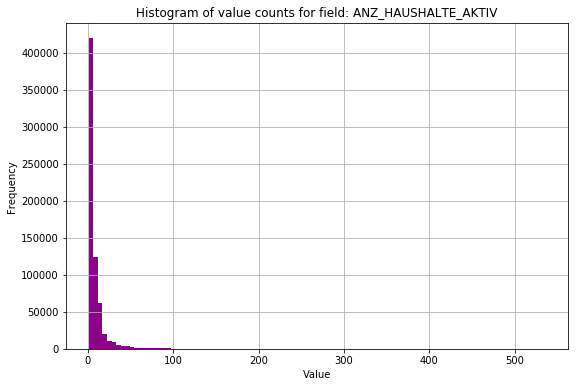

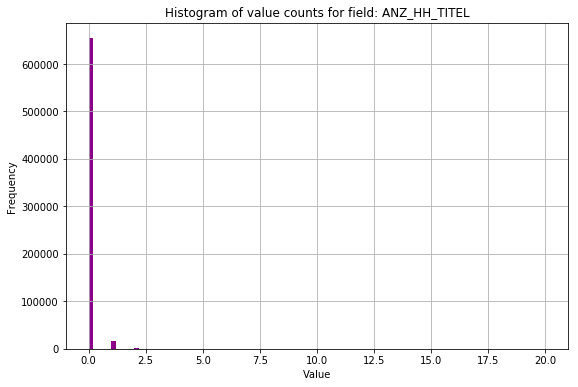

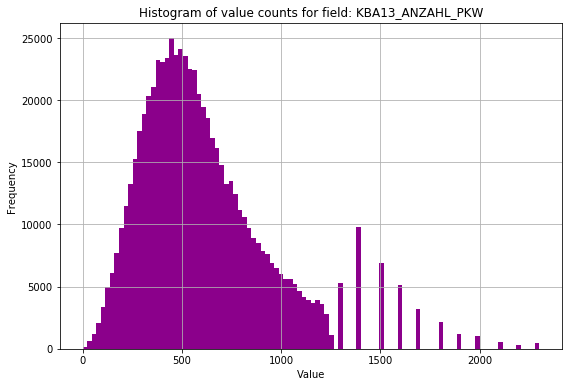

In [119]:
# ANZ_HAUSHALTE_AKTIV: Number of households in the building
# ANZ_HH_TITEL: Number of professional academic title holders in building
# KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region

# Visualise distribution of values for each of these fields to inform imputation decision
for col in missing_value_cols: 
    fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(demo_df.loc[~demo_df[col].isnull(),col], bins=100, color='darkmagenta')
    ax.set_title(f'Histogram of value counts for field: {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid();


In [120]:
# Given the nature and distribution of the ANZ_HAUSHALTE_AKTIV and ANZ_HH_TITEL fields, 
# I'm going to the impute missing values in these fields with their modes
col_modes = demo_df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL']].mode()
demo_df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL']]=demo_df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL']].fillna(col_modes.iloc[0])

# The measurement bins for the KBA13_ANZAHL_PKW field appear to change over the range of values,
# so the mode won't be the best approach for filling the missing values.  
# I'll fill the missing values with the mean value of this feature
demo_df['KBA13_ANZAHL_PKW'] = demo_df['KBA13_ANZAHL_PKW'].fillna(demo_df.KBA13_ANZAHL_PKW.mean())

In [121]:
# Display count of reamaining missing values.  This should be 0!
demo_df.isnull().sum().sum()

0

In [122]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler()
demo_ss = pd.DataFrame(ss.fit_transform(demo_df), columns=demo_df.columns)

In [123]:
demo_ss.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHR_MOVEMENT_mainstream,PRAEGENDE_JUGENDJAHR_GEN_50s,PRAEGENDE_JUGENDJAHR_GEN_60s,PRAEGENDE_JUGENDJAHR_GEN_70s,PRAEGENDE_JUGENDJAHR_GEN_80s,PRAEGENDE_JUGENDJAHR_GEN_90s,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,PLZ8_BAUMAX_TYPE_family
count,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,...,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05,6.749100e+05
mean,1.074484e-16,-9.062470e-17,-2.320363e-17,6.304144e-17,-7.636984e-17,3.784803e-17,1.370320e-16,-1.764487e-17,3.492125e-17,-2.435749e-16,...,-8.885601e-18,2.017158e-17,5.642988e-18,-3.086799e-17,-4.343311e-17,-3.465805e-17,-4.737583e-19,4.400688e-17,1.394323e-16,-5.851442e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.738859e+00,-1.023539e+00,-1.518339e+00,-1.144427e+00,-1.762873e+00,-1.245942e+00,-1.143631e+00,-1.553503e+00,-5.466905e-01,-1.614291e+00,...,-3.940936e-01,-1.829189e+00,-3.305358e-01,-4.245549e-01,-5.464162e-01,-4.932698e-01,-6.375774e-01,-1.544909e+00,-1.262910e+00,-2.648151e+00
25%,-7.665360e-01,-1.023539e+00,-7.866732e-01,-1.144427e+00,-1.041324e+00,-1.245942e+00,-1.143631e+00,-8.263719e-01,-5.466905e-01,-2.914194e-01,...,-3.940936e-01,5.466905e-01,-3.305358e-01,-4.245549e-01,-5.464162e-01,-4.932698e-01,-6.375774e-01,-8.634502e-01,-1.262910e+00,3.776220e-01
50%,2.057868e-01,9.770020e-01,-5.500696e-02,2.172964e-01,4.017735e-01,1.296433e-01,-4.162151e-01,-9.924030e-02,-5.466905e-01,-2.914194e-01,...,-3.940936e-01,5.466905e-01,-3.305358e-01,-4.245549e-01,-5.464162e-01,-4.932698e-01,-6.375774e-01,4.994682e-01,7.958369e-02,3.776220e-01
75%,1.178110e+00,9.770020e-01,6.766593e-01,8.981579e-01,1.123322e+00,8.174359e-01,1.038617e+00,6.278913e-01,-5.466905e-01,1.031452e+00,...,-3.940936e-01,5.466905e-01,-3.305358e-01,-4.245549e-01,-5.464162e-01,-4.932698e-01,1.568437e+00,1.180927e+00,7.508305e-01,3.776220e-01
max,1.178110e+00,9.770020e-01,1.408326e+00,1.579019e+00,1.123322e+00,1.505229e+00,1.766033e+00,1.355023e+00,1.829189e+00,1.031452e+00,...,2.537468e+00,5.466905e-01,3.025391e+00,2.355408e+00,1.830107e+00,2.027288e+00,1.568437e+00,1.180927e+00,1.422077e+00,3.776220e-01


In [124]:
# Sanity check mean=0 and std=1 for each column
print(f'Sum of means across features: {demo_ss.describe().loc["mean",:].sum()}')
print(f'Sum of stds across features: {demo_ss.describe().loc["std",:].sum()}')
print(demo_ss.shape)

Sum of means across features: 3.658481935639553e-14
Sum of stds across features: 176.0001303879003
(674910, 176)


### Discussion 2.1: Apply Feature Scaling

Prior to standardising the values for all features, I needed to impute the remaining missing values.  Following previous data cleaning efforts, the only features with missing values were numeric features.  After analysing the nature of these fields and the distribution of their values, I determined that it was most appropriate to impute the missing values with the mode for the ANZ_HAUSHALTE_AKTIV and ANZ_HH_TITEL fields and the mean value for the KBA13_ANZAHL_PKW field.

After confirming there were no more missing values in the dataset, I then standardised the data to remove the effects of the different scales of the features.  The mean and standard deviation of each feature is now 0 and 1 respectively, as demonstrated in the 2 cells immediately above.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [125]:
# Apply PCA to the data and store transformed data as a dataframe

pca=PCA()

demo_pca = pd.DataFrame(pca.fit_transform(demo_ss), \
                       columns=[f'PCA_{i+1}' for i in range(pca.n_components_)])


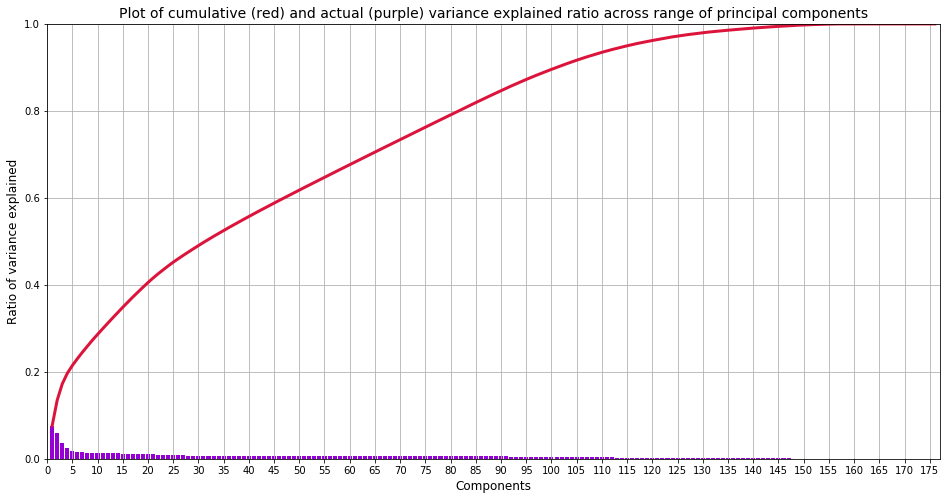

In [126]:
# Investigate the variance accounted for by each principal component

# PLot the cumulative and actual variance explained by each principal component

fig, ax = plt.subplots(figsize=(16,8))
ind = list(range(1, pca.n_components_+1))
vals = pca.explained_variance_ratio_
cum_vals = np.cumsum(pca.explained_variance_ratio_)
# Plot cumulative variance explained as a line plot
ax.plot(ind, cum_vals, color='crimson', lw=3)
# Plot variance explained by each component as a bar chart
ax.bar(ind, vals, color='darkviolet')
ax.set_ylim(0, 1.0)
ax.set_xlim(min(ind)-1, max(ind)+1)
ax.set_xticks(list(range(0,pca.n_components_+2, 5))) 
ax.set_ylabel('Ratio of variance explained', size=12)
ax.set_xlabel('Components', size=12) 
ax.set_title('Plot of cumulative (red) and actual (purple) variance explained ratio \
across range of principal components', size=14)
ax.grid() ;


In [127]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=101)

demo_pca = pd.DataFrame(pca.fit_transform(demo_ss), \
                       columns=[f'PCA_{i+1}' for i in range(pca.n_components_)])

In [128]:
print(demo_pca.shape)
print(f'Dataset variance explained: {round(pca.explained_variance_ratio_.sum()*100,1)}%.')

(674910, 101)
Dataset variance explained: 89.9%.


### Discussion 2.2: Perform Dimensionality Reduction

Just 5 principal components are needed to explain ~20% of variance within a datset consisting of 176 features.  19, 81 and 101  principal components are required to explain 40%, 80% and 90% of the variance in the dataset respectively.

Unfortunately, there isn't a distinct elbow in the scree plot above to provide strong direction in terms of the optimum number 
of principal components to use.  Beyond 35 components, the scree plot is almost linear.

I'm keen to retain as much information as is reasonably possible, so have chosen to retain 101 principal components - explaining 90% of the variance in my dataset.  This has the effect of reducing the dimensionality of my datset by 75 features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [129]:
# Create a dataframe of the principal components, with components as rows and 
# feature weightings as columns
components = pd.DataFrame(pca.components_, \
                          index=['{}'.format(i) for i in range(1,len(pca.components_)+1)], 
                          columns=demo_ss.columns)

# Define a function that takes an integer component number (starting at 1) and prints the
# varience explained by this component, as well as the 5 largest positive and negative
# feature weights that make up this component
def display_component_weights(i):
    sorted_features = components.loc[str(i),:].sort_values(ascending=False)
    print(f'Principal component {i} explains {round(pca.explained_variance_ratio_[i-1]*100,2)}% of the \
variance in the dataset.')
    print(f'\nThe 5 largest, positive weighted features and their weights for this component are: \n{sorted_features[:5]}')
    print(f'\nThe 5 largest, negative weighted features and their weights for this component are: \
    \n{sorted_features[-5:].sort_values(ascending=True)}')



In [130]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display_component_weights(1)

Principal component 1 explains 7.56% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
FINANZ_SPARER             0.185884
HH_EINKOMMEN_SCORE        0.179472
CAMEO_INTL_2015_WEALTH    0.174111
PLZ8_ANTG3                0.163720
PLZ8_ANTG4                0.160520
Name: 1, dtype: float64

The 5 largest, negative weighted features and their weights for this component are:     
FINANZ_MINIMALIST   -0.219557
MOBI_REGIO          -0.192659
KBA05_ANTG1         -0.182316
KBA05_GBZ           -0.168919
PLZ8_ANTG1          -0.168348
Name: 1, dtype: float64


In [131]:
# Description of 10 fields above:

# FINANZ_SPARER - SPARER: Financial typology - money-saver
# HH_EINKOMMEN_SCORE - Estimated household net income
# CAMEO_INTL_2015 – Wealth
# PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
# PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region

# FINANZ_MINIMALIST - MINIMALIST: Financial typology - low financial interest
# MOBI_REGIO - Movement patterns
# KBA05_ANTG1 - Number of 1-2 family houses in the microcell
# KBA05_GBZ - Number of buildings in the microcell
# PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region


In [132]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display_component_weights(2)

Principal component 2 explains 5.89% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
ALTERSKATEGORIE_GROB    0.195470
ZABEOTYP_3.0            0.191484
FINANZ_VORSORGER        0.178157
SEMIO_ERL               0.167547
FINANZ_HAUSBAUER        0.148124
Name: 2, dtype: float64

The 5 largest, negative weighted features and their weights for this component are:     
SEMIO_REL               -0.192849
FINANZ_UNAUFFAELLIGER   -0.190426
SEMIO_TRADV             -0.179877
SEMIO_PFLICHT           -0.176009
FINANZ_SPARER           -0.173295
Name: 2, dtype: float64


In [133]:
# Description of 10 fields above:

# ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
# ZABEOTYP_3.0 - Energy consumption typology - fair supplied
# FINANZ_VORSORGER – Financial typology - be prepared
# SEMIO_ERL - Personality typology - event-oriented
# FINANZ_HAUSBAUER - Financial typology - home ownership

# SEMIO_REL - Personality typology - religious
# FINANZ_UNAUFFAELLIGER - Financial typology - inconspicuous
# SEMIO_TRADV - Personality typology - traditional minded
# SEMIO_PFLICHT - Personality typology - dutiful
# FINANZ_SPARER - SPARER: Financial typology - money-saver

In [134]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
display_component_weights(3)

Principal component 3 explains 3.74% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
SEMIO_VERT       0.334451
SEMIO_SOZ        0.264732
SEMIO_FAM        0.264370
SEMIO_KULT       0.250690
FINANZTYP_5.0    0.137638
Name: 3, dtype: float64

The 5 largest, negative weighted features and their weights for this component are:     
ANREDE_KZ    -0.358357
SEMIO_KAEM   -0.327743
SEMIO_DOM    -0.296512
SEMIO_KRIT   -0.263730
SEMIO_ERL    -0.194750
Name: 3, dtype: float64


In [135]:
# Description of 10 fields above:

# SEMIO_VERT - Personality typology - dreamful
# SEMIO_SOZ - Personality typology - socially minded
# SEMIO_FAM - Personality typology - family-minded
# SEMIO_KULT - Personality typology - cultural-minded
# FINANZTYP_5.0 - Descriptive financial type for individual - Investor

# ANREDE_KZ - Gender
# SEMIO_KAEM - Personality typology - combative attitude
# SEMIO_DOM - Personality typology - dominant-minded
# SEMIO_KRIT - Personality typology - critical-minded
# SEMIO_ERL - Personality typology - event-oriented

### Discussion 2.3: Interpret Principal Components

Principal component 1 explains 7.56% of variance and positively weights features related to personal financials (e.g ability to save, household income and wealth) as well as number of 6-10 and 10+ family houses in the PLZ8 region.  Since higher values for  these personal financials features are associated with lower inclination to save, household income and wealth - this principal component positively weights those with less general wealth living in areas with large households.  Conversely, it negatively weights those with high financial interests, low movement patterns and those living in areas with smaller households.  Generally speaking, this could be a poorer demographic.

Principal component 2 explains 5.9% of variance and positively weights estimated age, those with energy consumption that is 'fair supplied', those who don't have a financial leaning towards being prepared or home ownership and people with a low event-related personality.  Conversely, it negatively weights those with a low affinity for religion, a low affinity with a  traditional or dutiful personality type and those with a low inclination to save money or be inconspicuous with their spending.  Generally speaking, this could be an investor-type profile.  

Principal component 3 explains 3.8% of variance and positively weights those with a low affinity for dreamful, socially, family or culturally minded personality and who identify as investors.  Conversely, it negatively weights females and those with a low affinity for a combative, dominant, critical and event related personality.  Generally, speaking this could be a dominant male type group.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [169]:
# Over a number of different cluster counts, ranging from 2 to 25...
# Fit K-Means clustering on data in principal component space
# and store inertia_ metric for each clustering structure

results = []
for cluster_num in range(2,26):
    print(f'Identifying {cluster_num} clusters...')
    
    # Fit K-Means for cluster_num clusters on the data's principal component space
    km = KMeans(n_clusters=cluster_num, random_state=10, n_jobs=-1, verbose=0)
    clusters = km.fit_transform(demo_pca)
    
    # Store number of clusters, combined with interia metric
    results.append([km.n_clusters, km.inertia_])
       

Identifying 2 clusters...
Identifying 3 clusters...
Identifying 4 clusters...
Identifying 5 clusters...
Identifying 6 clusters...
Identifying 7 clusters...
Identifying 8 clusters...
Identifying 9 clusters...
Identifying 10 clusters...
Identifying 11 clusters...
Identifying 12 clusters...
Identifying 13 clusters...
Identifying 14 clusters...
Identifying 15 clusters...
Identifying 16 clusters...
Identifying 17 clusters...
Identifying 18 clusters...
Identifying 19 clusters...
Identifying 20 clusters...
Identifying 21 clusters...
Identifying 22 clusters...
Identifying 23 clusters...
Identifying 24 clusters...
Identifying 25 clusters...


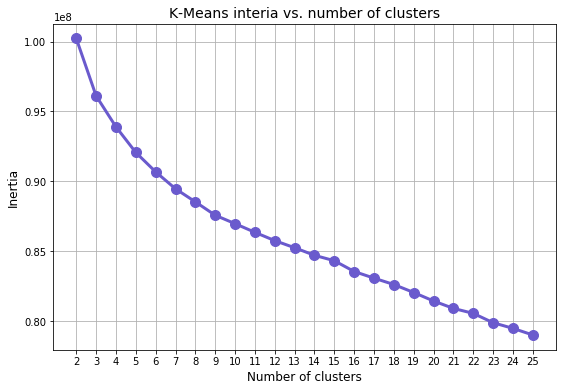

In [171]:
# Investigate the change in within-cluster distance across the range of cluster numbers.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Store clustering results in a dataframe
results_all = pd.DataFrame(results, columns=['cluster_num', 'inertia'])

# Create plot of K-Means inertia across a range of cluster numbers
fig, ax = plt.subplots(figsize=(9,6))
results_all.plot(x='cluster_num', y='inertia', color='slateblue', lw=3, marker='o', ms=10, ax=ax) 
ax.set_xlabel('Number of clusters', size=12)
ax.set_ylabel('Inertia', size=12)
ax.set_xticks(results_all.cluster_num.values)
ax.grid()
ax.get_legend().remove()
ax.set_title('K-Means interia vs. number of clusters', size=14)
display()

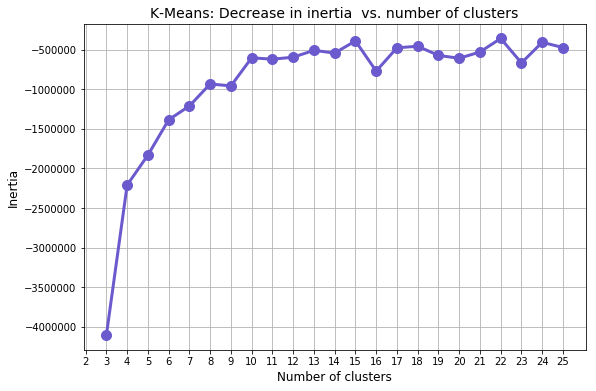

In [172]:
# Plot inertia gain realised with each additional cluster

results_all['inertia_diff'] = (results_all['inertia'].shift(-1) - results_all['inertia']).shift(1)

fig, ax = plt.subplots(figsize=(9,6))
results_all.plot(x='cluster_num', y='inertia_diff', color='slateblue', lw=3, marker='o', ms=10, ax=ax) 
ax.set_xlabel('Number of clusters', size=12)
ax.set_ylabel('Inertia', size=12)
ax.set_xticks(results_all.cluster_num.values)
ax.grid()
ax.get_legend().remove()
ax.set_title('K-Means: Decrease in inertia  vs. number of clusters', size=14)
display()

In [136]:
# Re-fit the k-means model with the selected number of clusters (9) and obtain
# cluster predictions for the general population demographics data.

km_pop = KMeans(n_clusters=9, random_state=10, n_jobs=-1, verbose=0)
pop_clusters = km_pop.fit_predict(demo_pca)

# Insert cluster_ids into demo_pca dataframe
demo_pca['cluster_id'] = pop_clusters

### Discussion 3.1: Apply Clustering to General Population

The scree plot of K-Means inertia vs. the number of clusters didn't yield an overly distinct elbow - but had an observable 'kink' around the 6-9 clusters range.  Plotting the inertia gain with each successive cluster confirms this kink, with inertia gains levelling after for more than 9 clusters.  Based on this, I've elected to cluster the population data into 9 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [140]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [141]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_df = clean_data(customers)

Coverting all missing and unknown values in data to NaNs
Removing columns with > 200,000 missing values
Removing 55853 rows, with > 8 missing values
Dummifying categorical features

Engineering features from mixed-type categorical features:
PRAEGENDE_JUGENDJAHRE...
CAMEO_INTL_2015...
PLZ8_BAUMAX...

Dropping final features and rows as identified in previous analysis

Data cleaning complete!


In [142]:
# Display null value counts
customers_df.isnull().sum().sort_values(ascending=False)[:10]

ANZ_HAUSHALTE_AKTIV    345
ANZ_HH_TITEL           214
KBA13_ANZAHL_PKW        39
GFK_URLAUBERTYP_5.0      0
GFK_URLAUBERTYP_3.0      0
GFK_URLAUBERTYP_2.0      0
FINANZTYP_6.0            0
FINANZTYP_5.0            0
FINANZTYP_4.0            0
FINANZTYP_3.0            0
dtype: int64

In [143]:
# As expected, the same fields are left with missing values for the customer data, as the demographics data
# Impute these missing values in the customer data in the same way they were imputed for the demographics data

col_modes = customers_df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL']].mode()
customers_df[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL']]=customers_df[['ANZ_HAUSHALTE_AKTIV', \
                                                                    'ANZ_HH_TITEL']].fillna(col_modes.iloc[0])
customers_df['KBA13_ANZAHL_PKW'] = customers_df['KBA13_ANZAHL_PKW'].fillna(customers_df.KBA13_ANZAHL_PKW.mean())

In [144]:
# Before transforming data with objects fit to demographics data, ensure both datasets have the 
# same number of features. It's possible for this to be different given the dummification of categorical variables.
# e.g. the customer subset may not have the same range of values as the larger demnographics data
# for the dummified categorical features
print(demo_df.shape)
print(customers_df.shape)

(674910, 176)
(123224, 175)


In [145]:
# Identify and insert missing column in same index as the demographics data
missing_col = [col for col in demo_df.columns if col not in customers_df.columns]
missing_col

['GEBAEUDETYP_5.0']

In [146]:
# It appears that the GEBAEUDETYP feature does not have a value = 5.0 in the customers subset, but it
# did in the demographics subset.  Confirm this is the case:
print(azdias.GEBAEUDETYP.unique())
print(customers.GEBAEUDETYP.unique())

# This is the case.  Insert missing column into customers data in the same location as the demographics data.
# This is required to ensure the objects fit to the demographics data can be used to transform the customer data.
# Find index of missing column in demographics dataframe
print(list(demo_df.columns).index('GEBAEUDETYP_5.0'))

[ nan   8.   1.   3.   2.   6.   4.   5.]
[  1.  nan   8.   2.   3.   4.   6.]
92


In [147]:
# Insert missing column of 0s in customers data at this index
customers_df.insert(loc=92, column='GEBAEUDETYP_5.0', value=0.0)

# Compare updated dataframe shapes and check for no missing values and matching columns before transforming the 
# customer data
print(demo_df.shape)
print(customers_df.shape)
print(customers_df.isnull().sum().sum())
print((customers_df.columns != demo_df.columns).sum())

(674910, 176)
(123224, 176)
0
0


In [148]:
# Standardise customer data using standardiser fit to demographics data
customer_ss = pd.DataFrame(ss.transform(customers_df), columns=customers_df.columns)

# Transform data onto principal components fit to demographics data
customer_pca = pd.DataFrame(pca.transform(customer_ss), \
                       columns=[f'PCA_{i+1}' for i in range(pca.n_components_)])

In [149]:
# Generate customer cluster labels using K-Means fit to population data
cust_clusters = km_pop.predict(customer_pca)

# Insert cluster_ids into demo_pca dataframe
customer_pca['cluster_id'] = cust_clusters

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [156]:
# For the people/rows removed from the population dataset in step 1.1.3, I noticed that this group was qualitatively
# different to the remaining data, so I'll account for these data points in both the population and customer 
# data as a separate cluster

# Counts values for each cluster, insert additional cluster count for rows removed in step 1.1.3 
# and store in a dataframe
demo_cluster_counts = demo_pca.cluster_id.value_counts()
demo_cluster_counts = demo_cluster_counts.append(pd.Series(demo_s2.shape[0], index=[9]))

cust_cluster_counts = customer_pca.cluster_id.value_counts()
cust_cluster_counts = cust_cluster_counts.append(pd.Series(55853, index=[9]))

cluster_results = pd.DataFrame({'demo_counts': demo_cluster_counts,'cust_counts':cust_cluster_counts})

# Calculate proportion for each cluster id and insert in cluster_results dataframe
cluster_results['demo_prop'] = cluster_results.demo_counts / cluster_results.demo_counts.sum()
cluster_results['cust_prop'] = cluster_results.cust_counts / cluster_results.cust_counts.sum()


In [157]:
cluster_results

,demo_counts,cust_counts,demo_prop,cust_prop
0,96231,25676,0.121132,0.143380
1,81599,1092,0.102714,0.006098
2,73851,9304,0.092961,0.051955
3,30978,14410,0.038994,0.080468
4,92671,13552,0.116651,0.075677
5,78212,2173,0.098450,0.012134
6,67191,1043,0.084578,0.005824
7,64789,8764,0.081554,0.048940
8,89388,47210,0.112518,0.263630
9,119520,55853,0.150447,0.311894


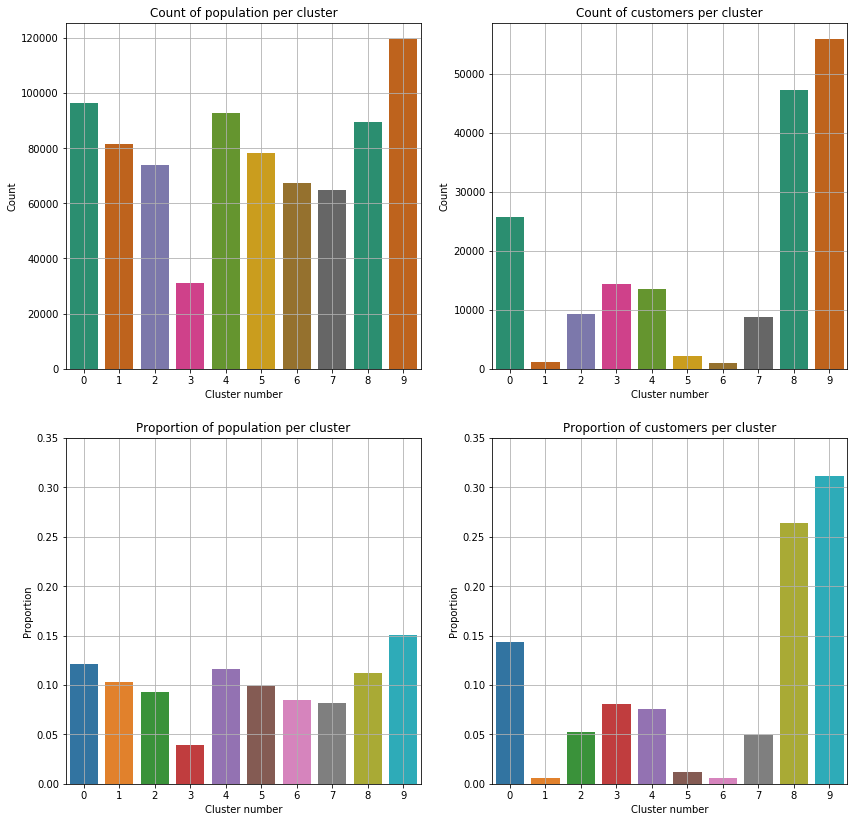

In [158]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Plot population and customer counts across the 9 clusters, as well as 
# proportions of population and customer assigned to each of the 9 clusters

fig,ax = plt.subplots(figsize=(14,14), ncols=2, nrows=2)
sns.barplot(x=cluster_results.index, y='demo_counts', data=cluster_results, palette='Dark2', ax=ax[0][0])
sns.barplot(x=cluster_results.index, y='cust_counts', data=cluster_results, palette='Dark2', ax=ax[0][1])
ax[0][0].set_title('Count of population per cluster')
ax[0][1].set_title('Count of customers per cluster')
sns.barplot(x=cluster_results.index, y='demo_prop', data=cluster_results, ax=ax[1][0])
sns.barplot(x=cluster_results.index, y='cust_prop', data=cluster_results, ax=ax[1][1])
ax[0][0].set_ylabel('Count')
ax[0][1].set_ylabel('Count')
ax[1][0].set_ylabel('Proportion')
ax[1][1].set_ylabel('Proportion')
ax[0][0].set_xlabel('Cluster number')
ax[0][1].set_xlabel('Cluster number')
ax[1][0].set_xlabel('Cluster number')
ax[1][1].set_xlabel('Cluster number')
ax[1][0].set_title('Proportion of population per cluster')
ax[1][1].set_title('Proportion of customers per cluster') 
ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()
ax[1][0].set_ylim(0,0.35)
ax[1][1].set_ylim(0,0.35) ;

In [160]:
cluster_results

,demo_counts,cust_counts,demo_prop,cust_prop
0,96231,25676,0.121132,0.143380
1,81599,1092,0.102714,0.006098
2,73851,9304,0.092961,0.051955
3,30978,14410,0.038994,0.080468
4,92671,13552,0.116651,0.075677
5,78212,2173,0.098450,0.012134
6,67191,1043,0.084578,0.005824
7,64789,8764,0.081554,0.048940
8,89388,47210,0.112518,0.263630
9,119520,55853,0.150447,0.311894


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 8 is over represented in the customer data, with approximately 26% of customers assigned to 
# cluster 8 vs. 11% of population.  

# Refer to analysis below for the type of people in this cluster.

In [330]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 1 is under represented in the customer data, with approximately <1% of customers assigned to 
# cluster 1 vs. 10% of population.

# Refer to analysis below for the type of people in this cluster.

In [171]:
# Store cluster centroid in a dataframe 
# Ignore cluster id that I added to the demo_pca dataframe
cluster_cents = pd.DataFrame(km_pop.cluster_centers_, columns=demo_pca.columns[:-1])

# Define function to display 3 largest positive and negative transformed values for a cluster_id's centroid
def display_extreme_transforms(cluster_id):
    sorted_pca = cluster_cents.loc[cluster_id, :].sort_values(ascending=False)
    print(f'\nThe 2 largest, positive extreme transformed values are: \n{sorted_pca[:2]}')
    print(f'\nThe 2 largest, negative extreme transformed values are: \n{sorted_pca[-2:].sort_values(ascending=True)}')


In [172]:
# Display 3 largest positive and negative transformed values for cluster 8's centroid
display_extreme_transforms(8)


The 2 largest, positive extreme transformed values are: 
PCA_4     3.071219
PCA_21    0.720087
Name: 8, dtype: float64

The 2 largest, negative extreme transformed values are: 
PCA_1   -4.496897
PCA_7   -1.258142
Name: 8, dtype: float64


In [173]:
# Display 5 largest positive and negative weighted features for the principal components 
# that have the most extreme values for cluster 8's centroids
for id in [4, 21, 1, 7]:
    display_component_weights(id)

Principal component 4 explains 2.44% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
GREEN_AVANTGARDE       0.349296
LP_STATUS_FEIN_10.0    0.296740
LP_STATUS_GROB_5.0     0.296740
PLZ8_ANTG3             0.125052
PLZ8_ANTG4             0.119266
Name: 4, dtype: float64

The 5 largest, negative weighted features and their weights for this component are:     
PRAEGENDE_JUGENDJAHR_MOVEMENT_mainstream   -0.349296
LP_STATUS_GROB_4.0                         -0.273647
LP_STATUS_FEIN_9.0                         -0.263325
HH_EINKOMMEN_SCORE                         -0.170806
INNENSTADT                                 -0.169090
Name: 4, dtype: float64
Principal component 21 explains 1.03% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
CAMEO_DEUG_2015_5       0.189562
LP_STATUS_FEIN_10.0     0.172677
LP_STATUS_GROB_5.0      0.172677
FINANZTYP_6.0           0.1

In [174]:
# Display 3 largest positive and negative transformed values for cluster 1's centroid
display_extreme_transforms(1)


The 2 largest, positive extreme transformed values are: 
PCA_1    4.859112
PCA_4    0.566485
Name: 1, dtype: float64

The 2 largest, negative extreme transformed values are: 
PCA_3   -2.771631
PCA_2   -0.791477
Name: 1, dtype: float64


In [176]:
# Display 5 largest positive and negative weighted features for the principal components 
# that have the most extreme values for cluster 1's centroids
for id in [1, 4, 3, 2]:
    display_component_weights(id)

Principal component 1 explains 7.56% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
FINANZ_SPARER             0.185884
HH_EINKOMMEN_SCORE        0.179472
CAMEO_INTL_2015_WEALTH    0.174111
PLZ8_ANTG3                0.163720
PLZ8_ANTG4                0.160520
Name: 1, dtype: float64

The 5 largest, negative weighted features and their weights for this component are:     
FINANZ_MINIMALIST   -0.219557
MOBI_REGIO          -0.192659
KBA05_ANTG1         -0.182316
KBA05_GBZ           -0.168919
PLZ8_ANTG1          -0.168348
Name: 1, dtype: float64
Principal component 4 explains 2.44% of the variance in the dataset.

The 5 largest, positive weighted features and their weights for this component are: 
GREEN_AVANTGARDE       0.349296
LP_STATUS_FEIN_10.0    0.296740
LP_STATUS_GROB_5.0     0.296740
PLZ8_ANTG3             0.125052
PLZ8_ANTG4             0.119266
Name: 4, dtype: float64

The 5 largest, negative weighted features 

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 8 was over represented / very popular with the mail-order company.  This group of people is characterised by 'green advantagarde (membership in environmental sustainability as part of youth) - rather than mainstream - higher incomes, residents closer to city centres who don't own their own homes. 

Cluster 3 was under represented within the mail-order company.  This group of the population is a poorer demographic, characterised by a lower inclination to save, lower household income and less wealth, living in areas with large households. Since principal component 3 has the highest negative weighting for this cluster's centroid, these people are likely to be dreamful, socially, family or culturally minded and unlikely to be investors.  